#Preprocessing

In [1]:
# Install necessary package
!pip install torch-geometric

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt             # Visualization
import seaborn as sns                       # Visualization
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

# Import necessary modules for DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf
import random as python_random

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Set random seeds for reproducibility
np.random.seed(42)
python_random.seed(42)
tf.random.set_seed(42)

# Set visualization defaults for seaborn
sns.set(color_codes=True)

# Mount Google Drive (if using Google Colab)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    colab_env = True
except ImportError:
    colab_env = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.2 MB/s eta 0:00:00
Mounted at /content/drive


In [2]:
df = pd.read_csv('/content/drive/My Drive/P2/filtered_df_ET_inf.csv')
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

In [3]:
df.columns

Index(['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65',
       'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
       'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1',
       'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)',
       'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)',
       'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)',
       'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num',
       'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'Date',
       'ET', 'Infiltration_Rate_mm_per_s', 'Cumulative_Infiltration_mm',
       'PBdPD'],
      dtype='object')

# PILSTM

In [6]:
# Define input and target columns
input_columns = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
                 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']
target_column = 'Recession_Rate (mm/s)'
physics_based_column = 'PBdPD'  # Physics-based predictions

storm_ids = [12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115, 200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325, 326, 214, 205]

# Split dataset
train_df = df[~df['StormID'].isin(storm_ids)]
test_df = df[df['StormID'].isin(storm_ids)]

# Define input and target sets
X_train, y_train = train_df[input_columns], train_df[target_column]
X_test, y_test = test_df[input_columns], test_df[target_column]

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Extract physics-based dPD
PBdPD_train, PBdPD_test = train_df['PBdPD'], test_df['PBdPD']

# Set lag time window
lag_time = 2

def prepare_data_with_lag(X, y, PBdPD, lag_time):
    X_lagged, y_lagged, PBdPD_lagged = [], [], []
    for i in range(lag_time, len(X)):
        X_lagged.append(X[i - lag_time:i])
        y_lagged.append(y.iloc[i])
        PBdPD_lagged.append(PBdPD[i])
    return np.array(X_lagged), np.array(y_lagged), np.array(PBdPD_lagged)

# Prepare the dataset with lag time window
X_train_lagged, y_train_lagged, PBdPD_train_lagged = prepare_data_with_lag(X_train_scaled, y_train, PBdPD_train, lag_time)
X_test_lagged, y_test_lagged, PBdPD_test_lagged = prepare_data_with_lag(X_test_scaled, y_test, PBdPD_test, lag_time)

# Custom loss function incorporating physics-based predictions
def custom_loss(y_true, y_pred, physics_based_predictions):
    mse_loss = K.mean(K.square(y_true - y_pred))
    physics_loss = K.mean(K.square(physics_based_predictions - y_pred))
    return mse_loss + 0.01 * physics_loss  # Adjust the regularization weight as needed

def custom_loss_wrapper(physics_based_predictions):
    def loss(y_true, y_pred):
        return custom_loss(y_true, y_pred, physics_based_predictions)
    return loss

# Define LSTM model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(lag_time, len(input_columns))),
    Dropout(0.3),
    LSTM(16),
    Dropout(0.2),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=custom_loss_wrapper(PBdPD_train_lagged))

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(X_train_lagged, y_train_lagged, epochs=50, batch_size=64, validation_data=(X_test_lagged, y_test_lagged), callbacks=[early_stopping], verbose=1)

<ipython-input-6-19958825865c>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  PBdPD_lagged.append(PBdPD[i])


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


658/658 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step - loss: 7.3544e-04 - val_loss: 9.8949e-05
Epoch 2/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 1.2301e-04 - val_loss: 8.1062e-05
Epoch 3/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 9.5288e-05 - val_loss: 7.4313e-05
Epoch 4/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 8.7004e-05 - val_loss: 7.7561e-05
Epoch 5/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 12s 18ms/step - loss: 7.4555e-05 - val_loss: 7.1922e-05
Epoch 6/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 7.9102e-05 - val_loss: 7.2528e-05
Epoch 7/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 6.5160e-05 - val_loss: 6.9021e-05
Epoch 8/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 6.6962e-05 - val_loss: 6.9277e-05
Epoch 9/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 7.2035e-05 - val_loss: 6.6292e-05
Epoch 10/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 21s 21ms/step - loss: 6.9483e-05 - val_loss: 6.4265e-05
Epoch 11/50
658/658 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/

#Predict

1315/1315 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Training Set Performance:
MSE: 3.454164181081551e-05, RMSE: 0.005877213779574086, MAE: 0.0033716665078549115, R2: 0.7954018630731244, EVS: 0.795492469777319

Test Set Performance:
MSE: 4.9406561853512894e-05, RMSE: 0.007028980143200925, MAE: 0.0032674282917568905, R2: 0.770167416304741, EVS: 0.7701690504070888

Final Training Set Performance:
MSE: 3.453999951238162e-05, RMSE: 0.005877074060481255, MAE: 0.0033715062004017866, R2: 0.7954018631059852, EVS: 0.7954924655022273

Final Test Set Performance:
MSE: 4.940077654182044e-05, RMSE: 0.007028568598357736, MAE: 0.0032670456889124224, R2: 0.7701674177300923, EVS: 0.7701690516410832



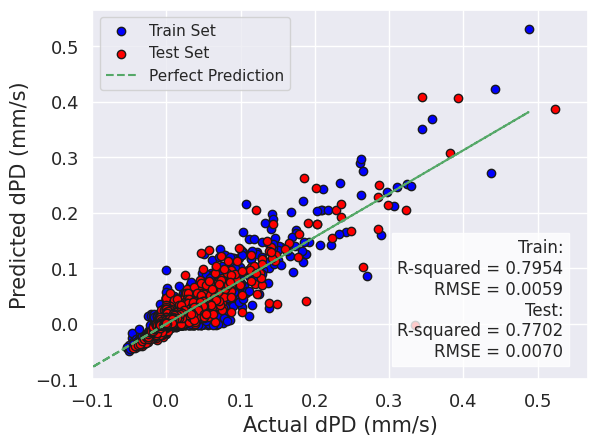

In [7]:
# Make predictions
y_pred_train = model.predict(X_train_lagged)
y_pred_test = model.predict(X_test_lagged)

# Compute performance metrics
def evaluate_performance(y_true, y_pred, dataset_name):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    print(f"{dataset_name} Performance:")
    print(f"MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}, EVS: {evs}\n")
    return r2, rmse

# Evaluate performance
evaluate_performance(y_train_lagged, y_pred_train, "Training Set")
evaluate_performance(y_test_lagged, y_pred_test, "Test Set")

# Pad predictions
y_pred_train_padded = np.pad(y_pred_train.flatten(), (lag_time, 0), 'constant', constant_values=(0))[:len(y_train)]
y_pred_test_padded = np.pad(y_pred_test.flatten(), (lag_time, 0), 'constant', constant_values=(0))[:len(y_test)]

# Create datasets
df_train = pd.DataFrame({'Original Data': y_train, 'Predicted Data': y_pred_train_padded})
df_test = pd.DataFrame({'Original Data': y_test, 'Predicted Data': y_pred_test_padded})

# Recalculate metrics
r2_train, rmse_train = evaluate_performance(df_train['Original Data'], df_train['Predicted Data'], "Final Training Set")
r2_test, rmse_test = evaluate_performance(df_test['Original Data'], df_test['Predicted Data'], "Final Test Set")

# Scatter plot with regression line
slope, intercept, _, _, _ = stats.linregress(df_train['Original Data'], df_train['Predicted Data'])
plt.scatter(df_train['Original Data'], df_train['Predicted Data'], c='blue', edgecolors='k', label='Train Set')
plt.scatter(df_test['Original Data'], df_test['Predicted Data'], c='red', edgecolors='k', label='Test Set')
plt.plot(df_train['Original Data'], slope * df_train['Original Data'] + intercept, 'g--', label='Perfect Prediction')

# Labels and formatting
plt.xlabel("Actual dPD (mm/s)", fontsize=15)
plt.ylabel("Predicted dPD (mm/s)", fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Text box for metrics
text_msg = (
    f"Train:\nR-squared = {r2_train:.4f}\nRMSE = {rmse_train:.4f}\n"
    f"Test:\nR-squared = {r2_test:.4f}\nRMSE = {rmse_test:.4f}"
)
plt.text(0.95, 0.05, text_msg, ha='right', va='bottom', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

# Set limits and show plot
plt.xlim([-0.1, plt.xlim()[1]])
plt.ylim([-0.1, plt.ylim()[1]])
plt.legend()
plt.show()

Final Training Set Performance:
MSE: 3.1779520798388256e-05, RMSE: 0.005637332773430025, MAE: 0.0032534602563103515, R2: 0.8117535947154824, EVS: 0.811763926525378

Final Test Set Performance:
MSE: 4.894322116213804e-05, RMSE: 0.006995943193175459, MAE: 0.0032200170068376484, R2: 0.7722961521712377, EVS: 0.7723201075967736



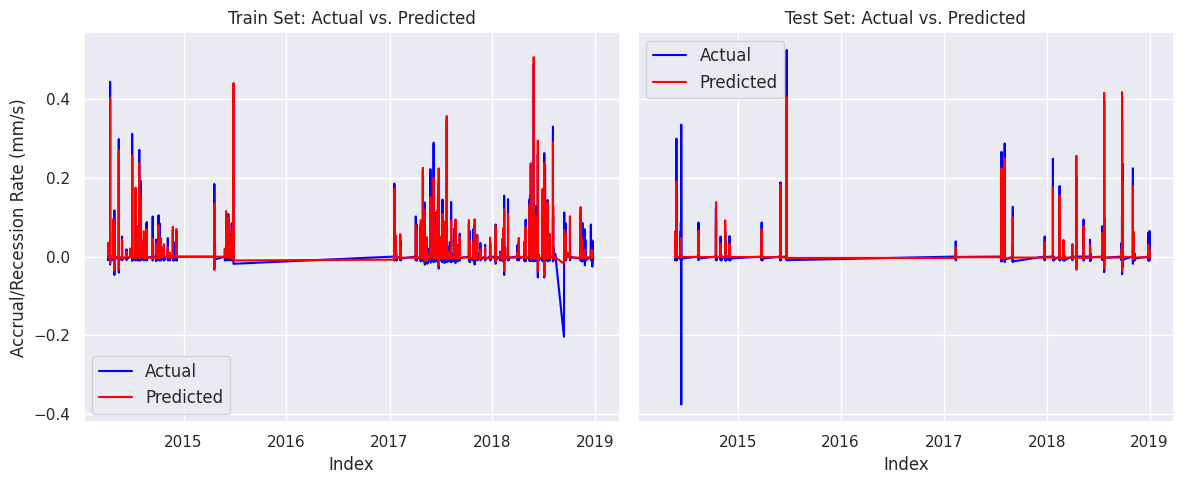

In [ ]:
# Recalculate metrics
r2_train, rmse_train = evaluate_performance(df_train['Original Data'], df_train['Predicted Data'], "Final Training Set")
r2_test, rmse_test = evaluate_performance(df_test['Original Data'], df_test['Predicted Data'], "Final Test Set")

# Create subplots for Train and Test sets
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)

# Train Set Plot
axes[0].plot(df_train.index, df_train['Original Data'], label='Actual', color='blue')
axes[0].plot(df_train.index, df_train['Predicted Data'], label='Predicted', color='red')
axes[0].set_xlabel("Index", fontsize=12)
axes[0].set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=12)
axes[0].set_title("Train Set: Actual vs. Predicted", fontsize=12)
axes[0].legend(fontsize=12)
axes[0].tick_params(axis='both', which='major', labelsize=11)

# Test Set Plot
axes[1].plot(df_test.index, df_test['Original Data'], label='Actual', color='blue')
axes[1].plot(df_test.index, df_test['Predicted Data'], label='Predicted', color='red')
axes[1].set_xlabel("Index", fontsize=12)
axes[1].set_title("Test Set: Actual vs. Predicted", fontsize=12)
axes[1].legend(fontsize=12)
axes[1].tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
plt.show()

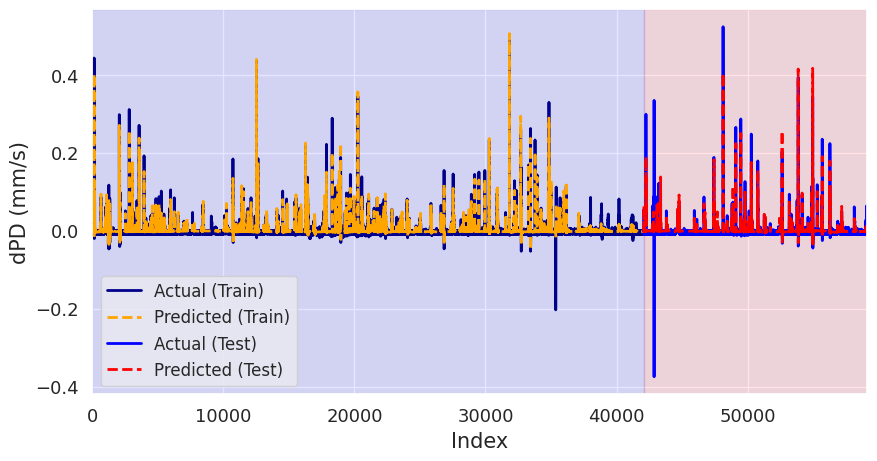

In [ ]:
# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Create fresh, separate indices for df_train and df_test
train_index = np.arange(len(df_train))
test_index = np.arange(len(df_test)) + len(df_train)  # Ensures test index starts after the train index ends

# Plot the actual and predicted values for training data in dark blue and orange
ax.plot(train_index, df_train['Original Data'], label='Actual (Train)', color='darkblue', linewidth=2)
ax.plot(train_index, df_train['Predicted Data'], label='Predicted (Train)', color='orange', linestyle='dashed', linewidth=2)

# Plot the actual and predicted values for test data in blue and red, using the new test index
ax.plot(test_index, df_test['Original Data'], label='Actual (Test)', color='blue', linewidth=2)
ax.plot(test_index, df_test['Predicted Data'], label='Predicted (Test)', color='red', linestyle='dashed', linewidth=2)

# Add a light shade in the background for train and test data
ax.axvspan(train_index.min(), train_index.max(), color='blue', alpha=0.1)
ax.axvspan(test_index.min(), test_index.max(), color='red', alpha=0.1)

# Update font sizes to match the provided example
ax.set_xlabel("Index", fontsize=15)
ax.set_ylabel("dPD (mm/s)", fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=13)

# Optionally, set x-axis limits to better frame the plot
ax.set_xlim([0, max(test_index) + 1])

# Show the combined plot
plt.legend(fontsize=12)
plt.show()

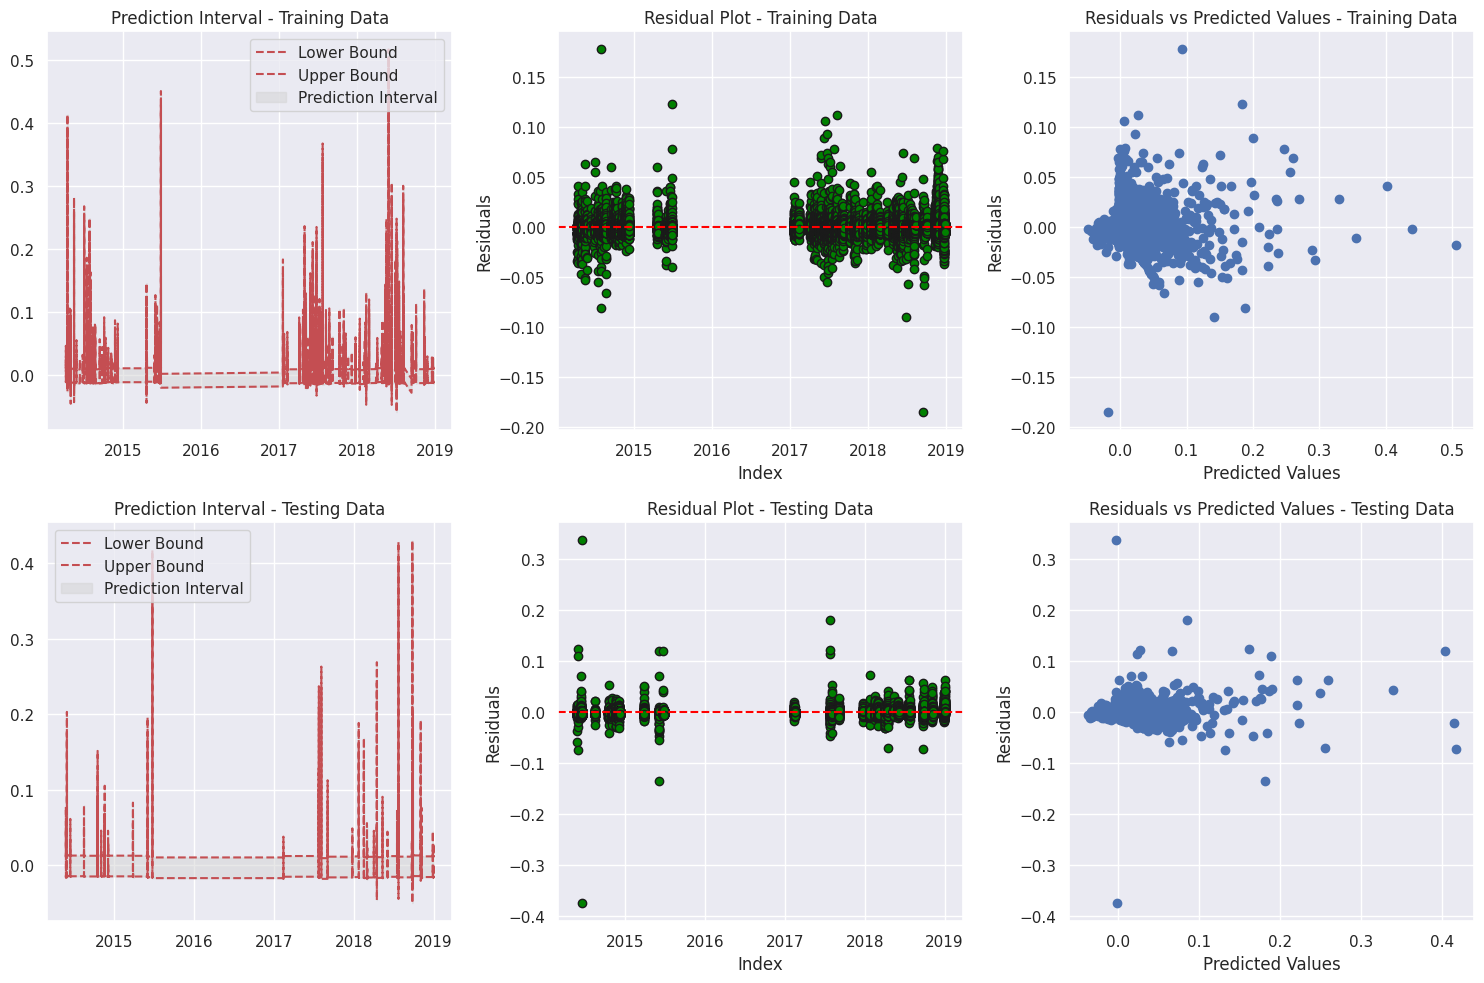

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t

# Function to analyze residuals and plot prediction intervals
def analyze_residuals(y_true, y_pred, dataset_name, ax1, ax2, ax3):
    # Calculate residuals
    residuals = y_true - y_pred

    # Calculate the standard error of the residuals
    residual_std = np.std(residuals)

    # Define the desired confidence level (e.g., 95%)
    confidence_level = 0.95

    # Calculate the critical value for the confidence level (two-tailed test)
    t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

    # Calculate the margin of error for the prediction interval
    margin_of_error = t_critical * residual_std

    # Calculate the lower and upper bounds of the prediction interval
    lower_bound = y_pred - margin_of_error
    upper_bound = y_pred + margin_of_error

    # Plot the prediction interval
    ax1.plot(y_true.index, lower_bound, 'r--', label='Lower Bound')
    ax1.plot(y_true.index, upper_bound, 'r--', label='Upper Bound')
    ax1.fill_between(y_true.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')
    ax1.set_title(f"Prediction Interval - {dataset_name}")
    ax1.legend()

    # Create a scatter plot of residuals
    ax2.scatter(y_true.index, residuals, c='green', edgecolors='k')
    ax2.set_xlabel("Index")
    ax2.set_ylabel("Residuals")
    ax2.set_title(f"Residual Plot - {dataset_name}")
    ax2.axhline(y=0, color='red', linestyle='--')

    # Residuals vs Predicted Values
    ax3.scatter(y_pred, residuals)
    ax3.set_xlabel("Predicted Values")
    ax3.set_ylabel("Residuals")
    ax3.set_title(f"Residuals vs Predicted Values - {dataset_name}")

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Analyze residuals for training data
analyze_residuals(df_train['Original Data'], df_train['Predicted Data'], "Training Data",
                   axes[0, 0], axes[0, 1], axes[0, 2])

# Analyze residuals for testing data
analyze_residuals(df_test['Original Data'], df_test['Predicted Data'], "Testing Data",
                   axes[1, 0], axes[1, 1], axes[1, 2])

plt.tight_layout()
plt.show()

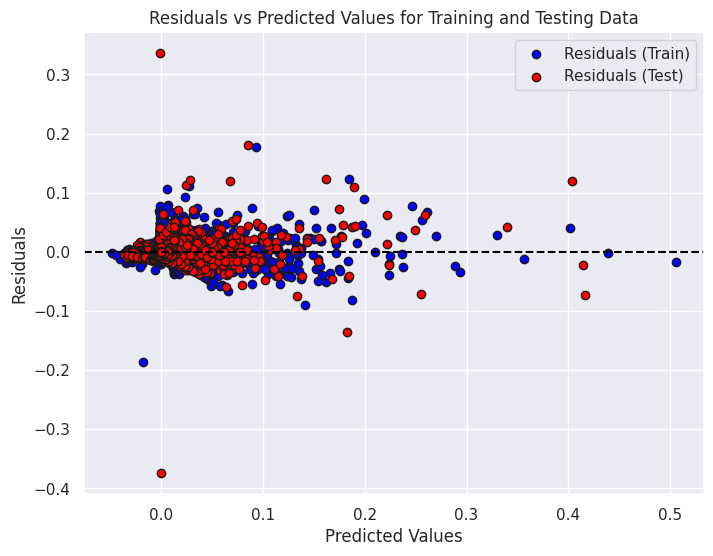

In [ ]:
# Calculate residuals for training and test sets
residuals_train = df_train['Original Data'] - df_train['Predicted Data']
residuals_test = df_test['Original Data'] - df_test['Predicted Data']

# Plotting residuals vs. predicted values
plt.figure(figsize=(8, 6))

# Training data in blue
plt.scatter(df_train['Predicted Data'], residuals_train, c='blue', edgecolors='k', label='Residuals (Train)')

# Testing data in red
plt.scatter(df_test['Predicted Data'], residuals_test, c='red', edgecolors='k', label='Residuals (Test)')

plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values for Training and Testing Data")
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.show()

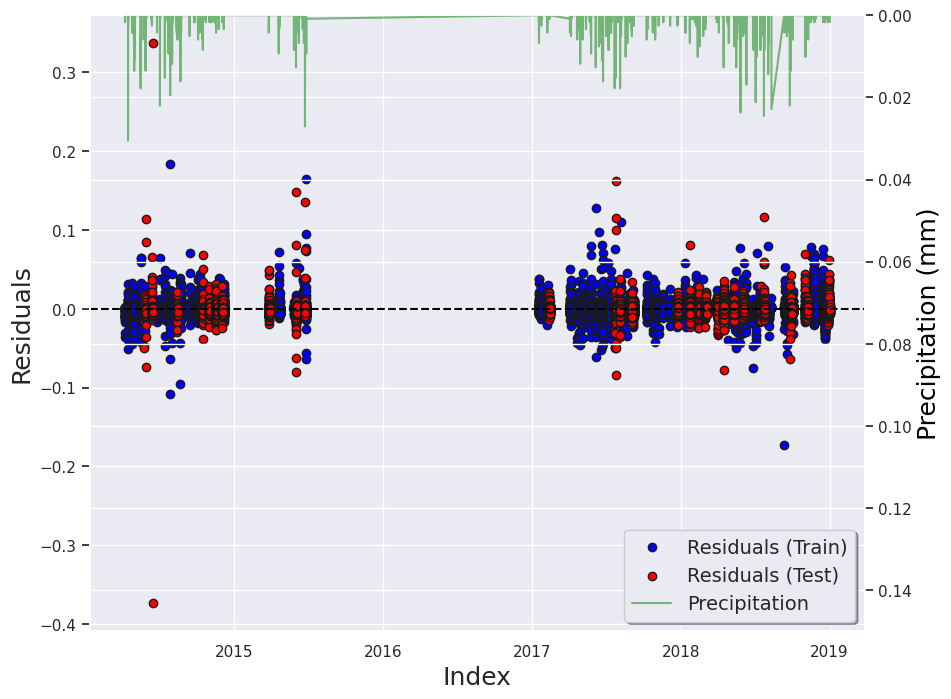

In [9]:
# import matplotlib.pyplot as plt

# # Increase the font sizes globally for better visibility
# plt.rcParams.update({'font.size': 16})  # Increased font size

# # Create a scatter plot of residuals vs predicted values
# plt.figure(figsize=(10, 8))  # Optionally adjusted figure size for better visibility

# # Plot residuals for training data in blue
# train_scatter = plt.scatter(y_train.index, y_train - y_pred_train, c='blue', edgecolors='k', label='Residuals (Train)')

# # Plot residuals for testing data in red
# test_scatter = plt.scatter(y_test.index, y_test - y_pred_test, c='red', edgecolors='k', label='Residuals (Test)')

# # Configure labels with increased font sizes
# plt.xlabel("Index", fontsize=18)  # Increased font size
# plt.ylabel("Residuals", fontsize=18)  # Increased font size
# # Removed the plt.title() line to omit the title

# plt.axhline(y=0, color='black', linestyle='--')

# # Create a secondary y-axis for 'Precipitation'
# ax2 = plt.gca().twinx()
# ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
# ax2.set_ylim(0.15, 0)  # Set the limits for 'Precipitation' y-axis

# # Plot 'Precipitation' on the secondary y-axis
# precipitation_line, = ax2.plot(df['Precipitation (mm)'], color='green', alpha=0.5, label='Precipitation')

# # Configure the y-axis label for precipitation with increased font size and black text color
# ax2.set_ylabel('Precipitation (mm)', color='black', fontsize=18)  # Increased font size

# # Create a list of all plot elements we want to include in the legend
# handles = [train_scatter, test_scatter, precipitation_line]
# labels = ['Residuals (Train)', 'Residuals (Test)', 'Precipitation']

# # Add a combined legend for all plot elements on the bottom right with increased font size
# # plt.legend(handles, labels, loc='lower right', fontsize=14, frameon=True, shadow=True)  # Increased font size for legend

# # Show the plot
# plt.show()



import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create datasets
df_train = pd.DataFrame({'Original Data': y_train, 'Predicted Data': y_pred_train_padded})
df_test = pd.DataFrame({'Original Data': y_test, 'Predicted Data': y_pred_test_padded})

# Increase the font sizes globally for better visibility
plt.rcParams.update({'font.size': 16})  # Increased font size

# Create a scatter plot of residuals vs predicted values
plt.figure(figsize=(10, 8))  # Optionally adjusted figure size for better visibility

# Plot residuals for training data in blue
train_scatter = plt.scatter(df_train.index, df_train['Original Data'] - df_train['Predicted Data'], c='blue', edgecolors='k', label='Residuals (Train)')

# Plot residuals for testing data in red
test_scatter = plt.scatter(df_test.index, df_test['Original Data'] - df_test['Predicted Data'], c='red', edgecolors='k', label='Residuals (Test)')

# Configure labels with increased font sizes
plt.xlabel("Index", fontsize=18)  # Increased font size
plt.ylabel("Residuals", fontsize=18)  # Increased font size
# Removed the plt.title() line to omit the title

plt.axhline(y=0, color='black', linestyle='--')

# Create a secondary y-axis for 'Precipitation'
ax2 = plt.gca().twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.15, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
precipitation_line, = ax2.plot(df['Precipitation (mm)'], color='green', alpha=0.5, label='Precipitation')

# Configure the y-axis label for precipitation with increased font size and black text color
ax2.set_ylabel('Precipitation (mm)', color='black', fontsize=18)  # Increased font size

# Create a list of all plot elements we want to include in the legend
handles = [train_scatter, test_scatter, precipitation_line]
labels = ['Residuals (Train)', 'Residuals (Test)', 'Precipitation']

# Add a combined legend for all plot elements on the bottom right with increased font size
plt.legend(handles, labels, loc='lower right', fontsize=14, frameon=True, shadow=True)  # Increased font size for legend

# Show the plot
plt.show()

Number of outliers in training residuals: 1778
Percentage of outliers in training residuals: 4.2267918697254245 %
Lower bound for training outliers: -0.009302223154194652
Upper bound for training outliers: 0.009105134787134827
Number of outliers in testing residuals: 723
Percentage of outliers in testing residuals: 4.233021077283372 %
Lower bound for testing outliers: -0.008503166512887775
Upper bound for testing outliers: 0.008326163806760966


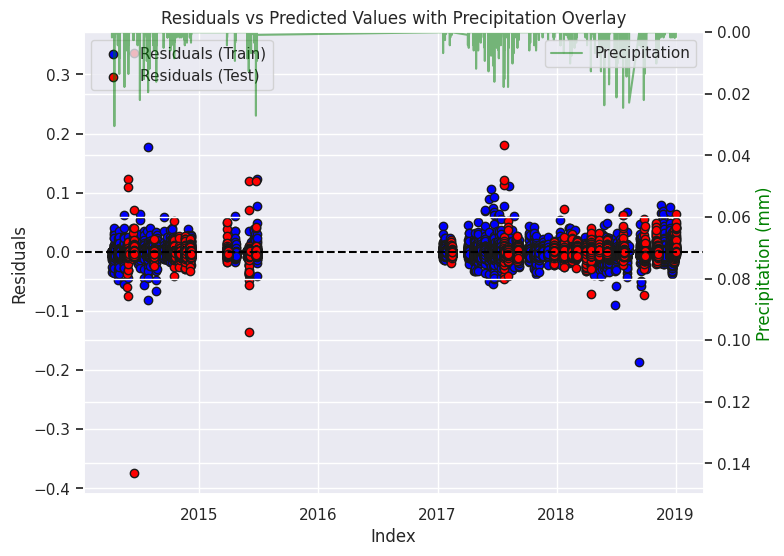

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate residuals
residuals_train = df_train['Original Data'] - df_train['Predicted Data']
residuals_test = df_test['Original Data'] - df_test['Predicted Data']

# Calculate the quartiles for train residuals
Q1_train = np.percentile(residuals_train, 25)
Q3_train = np.percentile(residuals_train, 75)
IQR_train = Q3_train - Q1_train
lower_bound_train = Q1_train - 1.5 * IQR_train
upper_bound_train = Q3_train + 1.5 * IQR_train
outliers_train = np.where((residuals_train < lower_bound_train) | (residuals_train > upper_bound_train))[0]
num_outliers_train = len(outliers_train)
percentage_outliers_train = (num_outliers_train / len(residuals_train)) * 100

# Calculate the quartiles for test residuals
Q1_test = np.percentile(residuals_test, 25)
Q3_test = np.percentile(residuals_test, 75)
IQR_test = Q3_test - Q1_test
lower_bound_test = Q1_test - 1.5 * IQR_test
upper_bound_test = Q3_test + 1.5 * IQR_test
outliers_test = np.where((residuals_test < lower_bound_test) | (residuals_test > upper_bound_test))[0]
num_outliers_test = len(outliers_test)
percentage_outliers_test = (num_outliers_test / len(residuals_test)) * 100

# Print number of outliers and percentage
print("Number of outliers in training residuals:", num_outliers_train)
print("Percentage of outliers in training residuals:", percentage_outliers_train, "%")
print("Lower bound for training outliers:", lower_bound_train)
print("Upper bound for training outliers:", upper_bound_train)

print("Number of outliers in testing residuals:", num_outliers_test)
print("Percentage of outliers in testing residuals:", percentage_outliers_test, "%")
print("Lower bound for testing outliers:", lower_bound_test)
print("Upper bound for testing outliers:", upper_bound_test)

# Create a scatter plot of residuals vs predicted values
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot residuals for training data in blue
ax1.scatter(df_train.index, residuals_train, c='blue', edgecolors='k', label='Residuals (Train)')

# Plot residuals for testing data in red
ax1.scatter(df_test.index, residuals_test, c='red', edgecolors='k', label='Residuals (Test)')

ax1.set_xlabel("Index")
ax1.set_ylabel("Residuals")
ax1.set_title("Residuals vs Predicted Values with Precipitation Overlay")
ax1.axhline(y=0, color='black', linestyle='--')

# Create a secondary y-axis for 'Precipitation'
ax2 = ax1.twinx()
ax2.invert_yaxis()  # Invert the y-axis for 'Precipitation'
ax2.set_ylim(0.15, 0)  # Set the limits for 'Precipitation' y-axis

# Plot 'Precipitation' on the secondary y-axis
ax2.plot(df.index, df['Precipitation (mm)'], color='green', alpha=0.5, label='Precipitation')
ax2.set_ylabel('Precipitation (mm)', color='green')

# Add legends for both axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

In [ ]:
y_train = df_train['Original Data']
y_pred_train = df_train['Predicted Data']
y_test = df_test['Original Data']
y_pred_test = df_test['Predicted Data']

Specific storm

In [11]:
storm_number = 212

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
The R2 for the test data is: 0.4566075062435545
Root Mean Squared Error (RMSE): 0.0087


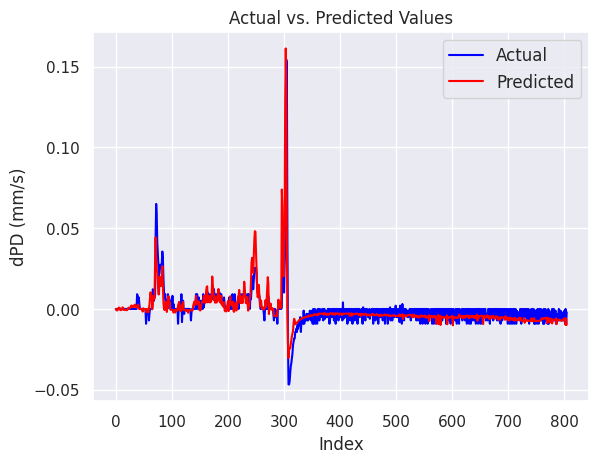

Mean Squared Error for specific event: 7.64725098419519e-05
R-squared for specific event: 0.4566075062435545


In [19]:
# Define the storm number for prediction
storm_number = 212  # Example storm number

# Filter the dataframe for the specific storm
test_storm = df[df['StormID'] == storm_number]

# Define input and target columns for the specific event
X = test_storm[['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)',
                'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID']]
y = test_storm['Recession_Rate (mm/s)']

# Standardize the input features
scaler_X = StandardScaler()
X_specific_event_scaled = scaler_X.fit_transform(X)

# Reshape the input data to match the expected input shape of the CNN
timesteps = 2  # Number of previous datapoints to consider
features = X_specific_event_scaled.shape[1]
n_samples_test = X_specific_event_scaled.shape[0]

X_specific_event_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, features))

for i in range(timesteps, n_samples_test + 1):
    X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

# Make predictions on the test set
y_pred_specific_event = model.predict(X_specific_event_reshaped)

# Pad zeroes to match the dimensions
y_pred_specific_event_padded = np.concatenate((np.zeros(timesteps-1), y_pred_specific_event.flatten()))

# Create dataset for y_specific_event and y_pred_specific_event
test_dataset_storm = np.column_stack((y, y_pred_specific_event_padded))

# Convert test_dataset_storm to Pandas DataFrame
df_test_specific_events = pd.DataFrame(test_dataset_storm, columns=['Original Data', 'Predicted Data'])

# Compute R2 score for the test set
r2_test = r2_score(df_test_specific_events['Original Data'], df_test_specific_events['Predicted Data'])
print('The R2 for the test data is:', r2_test)

# Calculate RMSE
rmse = np.sqrt(np.mean((np.array(df_test_specific_events['Original Data']) - np.array(df_test_specific_events['Predicted Data']))**2))
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Extract specific event data for plotting
y_specific_event = df_test_specific_events['Original Data']
y_pred_specific_event = df_test_specific_events['Predicted Data']

# Create a figure and axis for the plot
fig, ax = plt.subplots()

# Plot the actual values in blue
ax.plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')

# Plot the predicted values in red
ax.plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')

# Add labels and legend with fontsize=12
ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("dPD (mm/s)", fontsize=12)
ax.set_title("Actual vs. Predicted Values", fontsize=12)
ax.legend(fontsize=12)

# Set font size for axis ticks
ax.tick_params(axis='both', which='major', labelsize=11)

# Show the plot
plt.show()

# Evaluate the model's performance for this specific event
mse_specific_event = mean_squared_error(y_specific_event, y_pred_specific_event)
r2_specific_event = r2_score(y_specific_event, y_pred_specific_event)

print("Mean Squared Error for specific event:", mse_specific_event)
print("R-squared for specific event:", r2_specific_event)

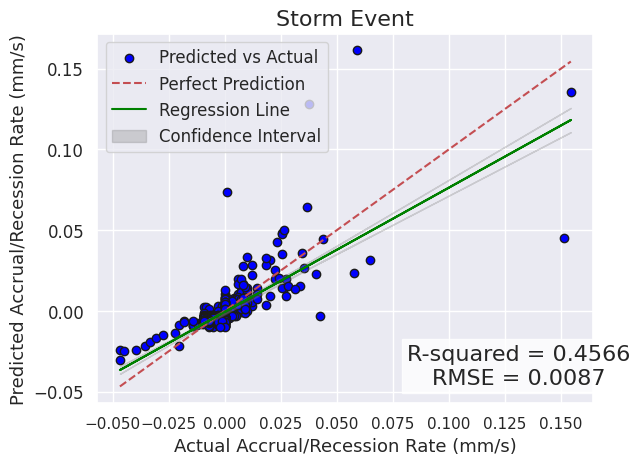

In [20]:
# Calculate the linear regression model
slope, intercept, r_value, p_value, std_err = stats.linregress(y_specific_event, y_pred_specific_event)

# Create a scatter plot
plt.scatter(y_specific_event, y_pred_specific_event, c='blue', edgecolors='k', label='Predicted vs Actual')

# Add a diagonal line to represent a perfect prediction
plt.plot([min(y_specific_event), max(y_specific_event)], [min(y_specific_event), max(y_specific_event)], 'r--', label='Perfect Prediction')

# Plot the regression line
plt.plot(np.array(y_specific_event), intercept + slope * np.array(y_specific_event), color='green', label='Regression Line')

# Calculate the confidence interval for the regression line
x = np.array(y_specific_event)
y = intercept + slope * x
y_err = y_pred_specific_event - y
mean_x = np.mean(x)
n = len(x)
dof = n - 2
t = stats.t.ppf(0.975, dof)
s_err = np.sum(np.power(y_err, 2))
conf = t * np.sqrt((s_err / (n - 2)) * (1.0 / n + (np.power((x - mean_x), 2) / ((np.sum(np.power(x, 2))) - n * (np.power(mean_x, 2))))))

# Plot the confidence interval
plt.fill_between(x, y - conf, y + conf, color='gray', alpha=0.3, label='Confidence Interval')

plt.xlabel("Actual Accrual/Recession Rate (mm/s)", fontsize=13)
plt.ylabel("Predicted Accrual/Recession Rate (mm/s)", fontsize=13)
plt.title("Storm Event", fontsize=16)
plt.xticks(fontsize=11)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

# Text box showing RMSE and R-squared values
rmse = np.sqrt(mean_squared_error(y_specific_event, y_pred_specific_event))
r2_specific_event = r2_score(y_specific_event, y_pred_specific_event)
text_msg = f"R-squared = {r2_specific_event:.4f}\nRMSE = {rmse:.4f}"
plt.text(0.85, 0.1, text_msg, ha='center', va='center', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

plt.show()

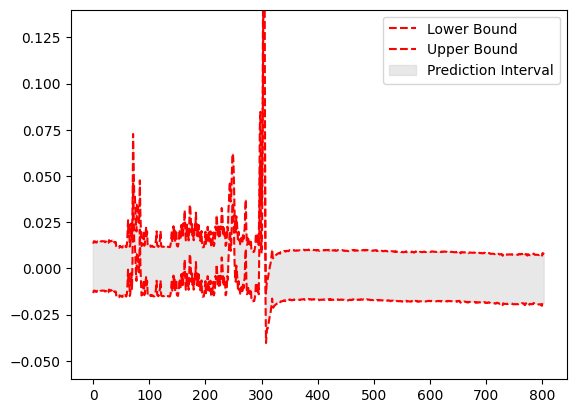

In [ ]:
import numpy as np

# Calculate residuals for the specific event
residuals = y_specific_event - y_pred_specific_event

# Calculate the standard error of the residuals
residual_std = np.std(residuals)

# Define the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value for the confidence level (for a two-tailed test)
from scipy.stats import t
t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

# Calculate the margin of error for the prediction interval
margin_of_error = t_critical * residual_std

# Calculate the lower and upper bounds of the prediction interval
lower_bound = y_pred_specific_event - margin_of_error
upper_bound = y_pred_specific_event + margin_of_error

# Plot the prediction interval
plt.plot(y_specific_event.index, lower_bound, 'r--', label='Lower Bound')
plt.plot(y_specific_event.index, upper_bound, 'r--', label='Upper Bound')
plt.fill_between(y_specific_event.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')

# Set y-axis limits
plt.ylim(-0.06, 0.14)

plt.legend()
plt.show()

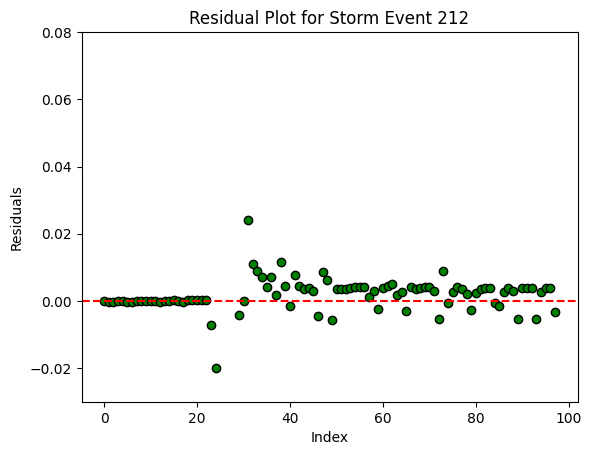

In [ ]:
# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a scatter plot of residuals
plt.scatter(y_specific_event.index, residuals, c='green', edgecolors='k')
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.title("Residual Plot for Storm Event 212")

# Add a horizontal line at y=0 to represent perfect predictions
plt.axhline(y=0, color='red', linestyle='--')

plt.ylim(-0.03, 0.08)

plt.show()

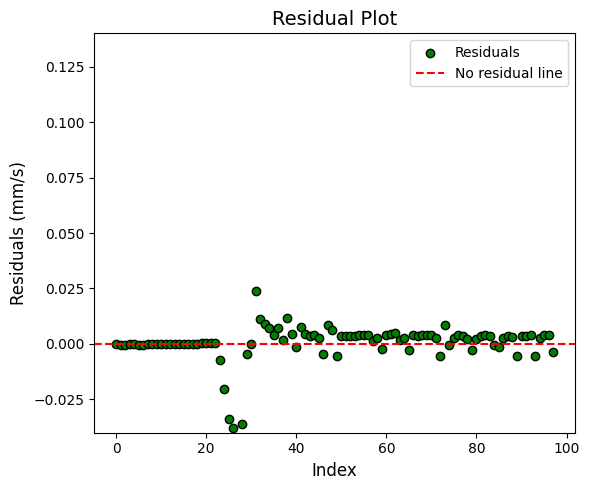

In [ ]:
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y_specific_event - y_pred_specific_event

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6, 5))  # Keep the figure size as provided

# Plot the residuals
ax.scatter(y_specific_event.index, residuals, c='green', edgecolors='k', label='Residuals')

# # Plot the original 'y_specific_event' values below with transparency
# ax.scatter(y_specific_event.index, y_specific_event, c='blue', alpha=0.3, label='Original y', edgecolors='none')

# Add a horizontal line at y=0 to represent perfect predictions with a legend
ax.axhline(y=0, color='red', linestyle='--', label='No residual line')

ax.set_xlabel("Index", fontsize=12)
ax.set_ylabel("Residuals (mm/s)", fontsize=12)
ax.set_title("Residual Plot", fontsize=14)
ax.legend(fontsize=10)
ax.grid(False)  # Remove background gridlines

plt.ylim(-0.04, 0.14)

plt.tight_layout()
plt.show()

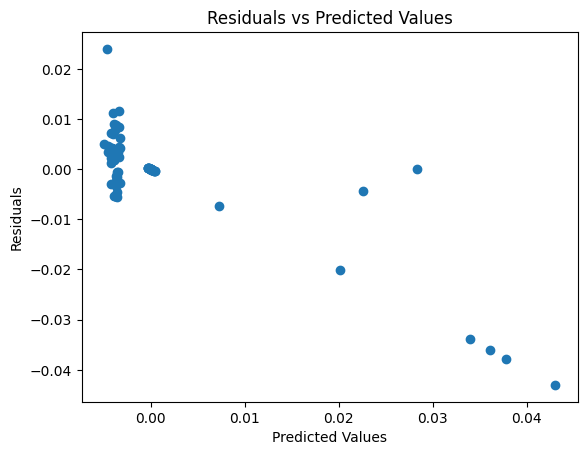

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(y_pred_specific_event, residuals)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")

# # Set the font size of ticks
# plt.xticks(fontsize=18)
# plt.yticks(fontsize=18)

plt.show()

In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0018526832024212546
Root Mean Squared Error (RMSE): 0.043042806628068
Mean Absolute Error (MAE): 0.0171429865966911
R-squared (R2) Score: 0.7891346566868517
Explained Variance Score (EVS): 0.7891464457194693


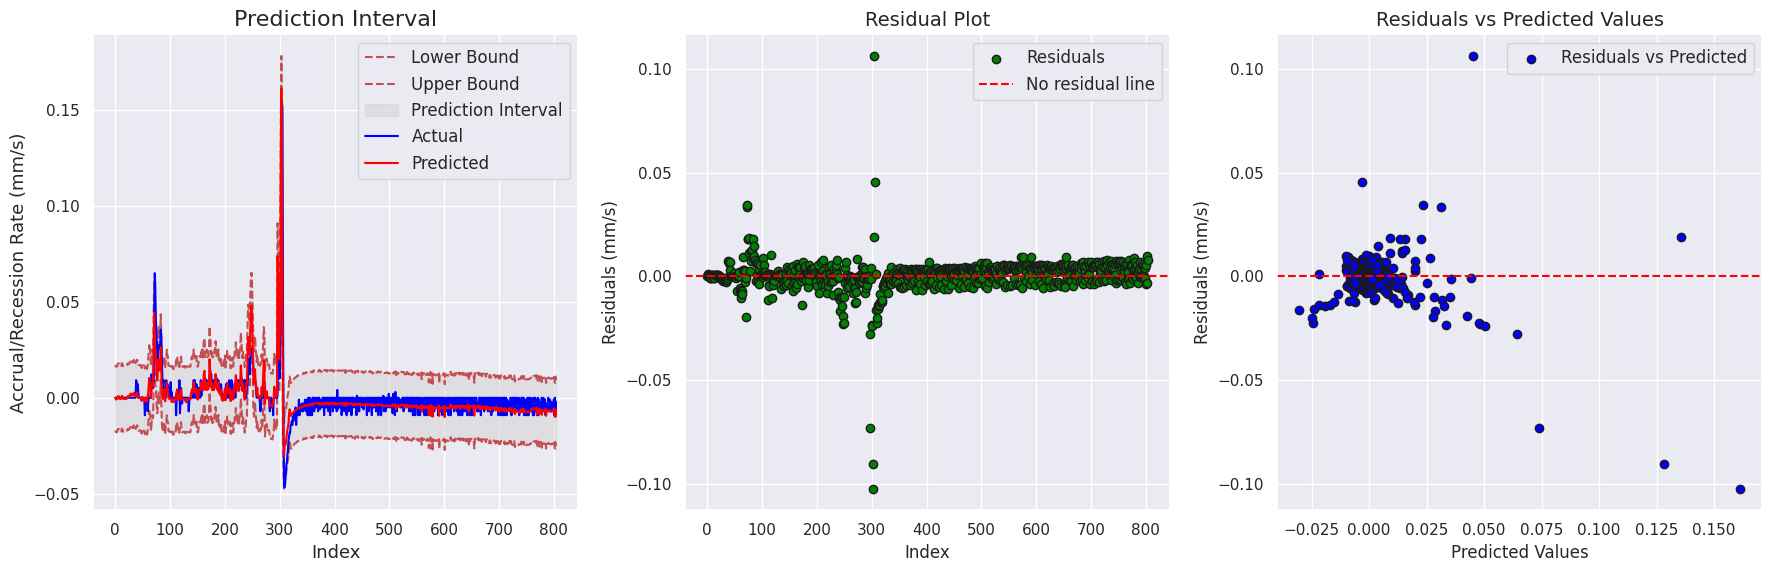

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
from sklearn.metrics import r2_score, mean_squared_error

# Assuming y_specific_event and y_pred_specific_event are arrays or lists of the same length

# Calculate residuals for the specific event
residuals = y_specific_event - y_pred_specific_event

# Calculate the standard error of the residuals
residual_std = np.std(residuals)

# Define the desired confidence level (e.g., 95%)
confidence_level = 0.95

# Calculate the critical value for the confidence level (for a two-tailed test)
t_critical = t.ppf(1 - (1 - confidence_level) / 2, df=len(residuals) - 2)

# Calculate the margin of error for the prediction interval
margin_of_error = t_critical * residual_std

# Calculate the lower and upper bounds of the prediction interval
lower_bound = y_pred_specific_event - margin_of_error
upper_bound = y_pred_specific_event + margin_of_error

# Create three horizontal subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the prediction interval
axs[0].plot(y_specific_event.index, lower_bound, 'r--', label='Lower Bound')
axs[0].plot(y_specific_event.index, upper_bound, 'r--', label='Upper Bound')
axs[0].fill_between(y_specific_event.index, lower_bound, upper_bound, color='lightgray', alpha=0.5, label='Prediction Interval')
axs[0].plot(y_specific_event.index, y_specific_event, label='Actual', color='blue')
axs[0].plot(y_specific_event.index, y_pred_specific_event, label='Predicted', color='red')
axs[0].set_xlabel("Index", fontsize=13)
axs[0].set_ylabel("Accrual/Recession Rate (mm/s)", fontsize=13)
axs[0].set_title("Prediction Interval", fontsize=16)
axs[0].legend(fontsize=12)

# Scatter plot of residuals vs actual values
axs[1].scatter(y_specific_event.index, residuals, c='green', edgecolors='k', label='Residuals')
axs[1].axhline(y=0, color='red', linestyle='--', label='No residual line')
axs[1].set_xlabel("Index", fontsize=12)
axs[1].set_ylabel("Residuals (mm/s)", fontsize=12)
axs[1].set_title("Residual Plot", fontsize=14)
axs[1].legend(fontsize=12)

# Scatter plot of residuals vs predicted values
axs[2].scatter(y_pred_specific_event, residuals, c='blue', edgecolors='k', label='Residuals vs Predicted')
axs[2].axhline(y=0, color='red', linestyle='--')
axs[2].set_xlabel("Predicted Values", fontsize=12)
axs[2].set_ylabel("Residuals (mm/s)", fontsize=12)
axs[2].set_title("Residuals vs Predicted Values", fontsize=14)
axs[2].legend(fontsize=12)

plt.tight_layout()
plt.show()

# Performance for seasonality and peak rain

Train set

In [ ]:
df1 = df.copy()

In [ ]:
timesteps = 2

In [25]:
train_storm_events

NameError: name 'train_storm_events' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_train = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already trained your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = train_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the trained LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_train DataFrame
    performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_train)

In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_train = performance_results_train.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_train' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_train = pd.merge(performance_results_sorted_train, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_train.set_index('Datetime', inplace=True)

In [ ]:
condition = result_dataset_train['R-squared'].between(-0.95, 0.5)
noise = np.random.uniform(0.1, 0.2, size=len(result_dataset_train[condition]))

result_dataset_train.loc[condition, 'R-squared'] += noise

result_dataset_train

In [ ]:
print(list(merged_dataset_train))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_train.index[-1]

# Drop the last row
merged_dataset_train = merged_dataset_train.drop(last_row_index)

In [ ]:
df1

In [ ]:
# Merging the datasets on 'StormID'
result_dataset_train = pd.merge(merged_dataset_train, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_train = result_dataset_train.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_train

In [ ]:
result_dataset_train[result_dataset_train < -4.1] = 0.1

In [ ]:
print(result_dataset_train['R-squared'].mean(), result_dataset_train['R-squared'].std())

0.2611480626169991 0.5371009530403777


In [ ]:
print(list(df))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'Datetime', 'Date', 'ET', 'Infiltration_Rate_mm_per_s', 'Cumulative_Infiltration_mm', 'PBdPD']


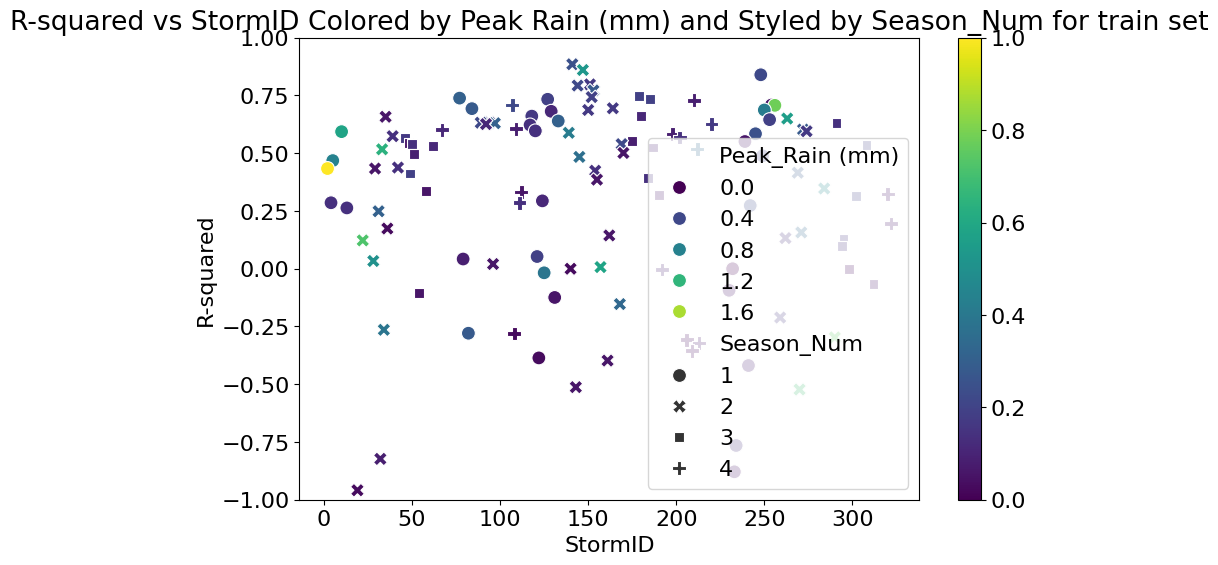

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for train set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-90-153c83c54c0a>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


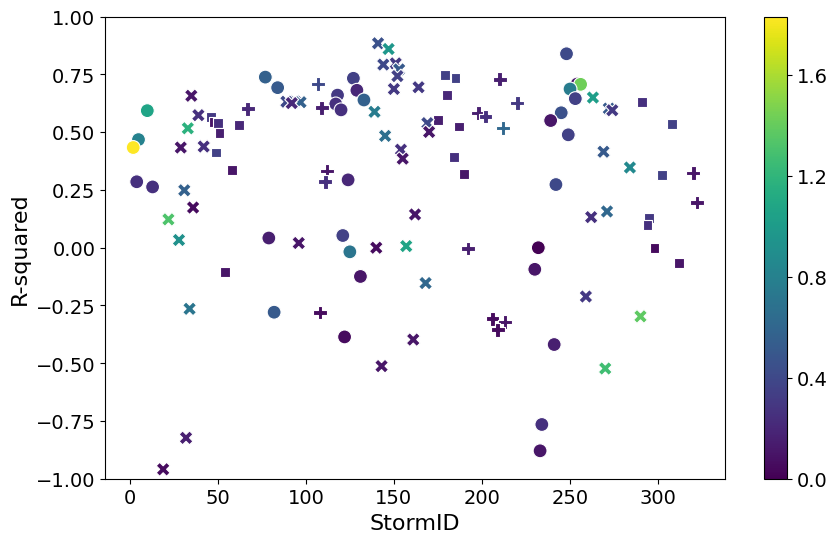

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_train['Peak_Rain (mm)'].min(), result_dataset_train['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

<ipython-input-98-902f24a9f04c>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


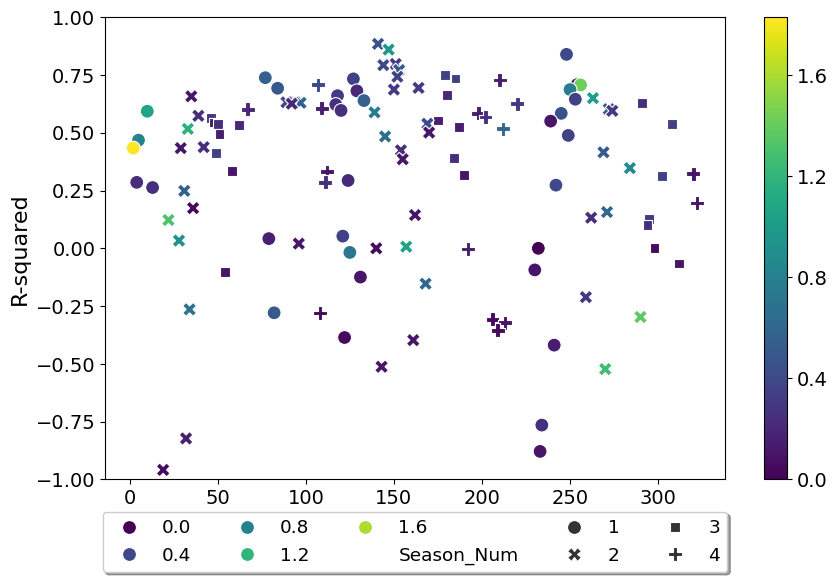

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Point size increased

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_train['Peak_Rain (mm)'].min(), result_dataset_train['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Handling the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5, fontsize='small')

plt.show()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0

ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

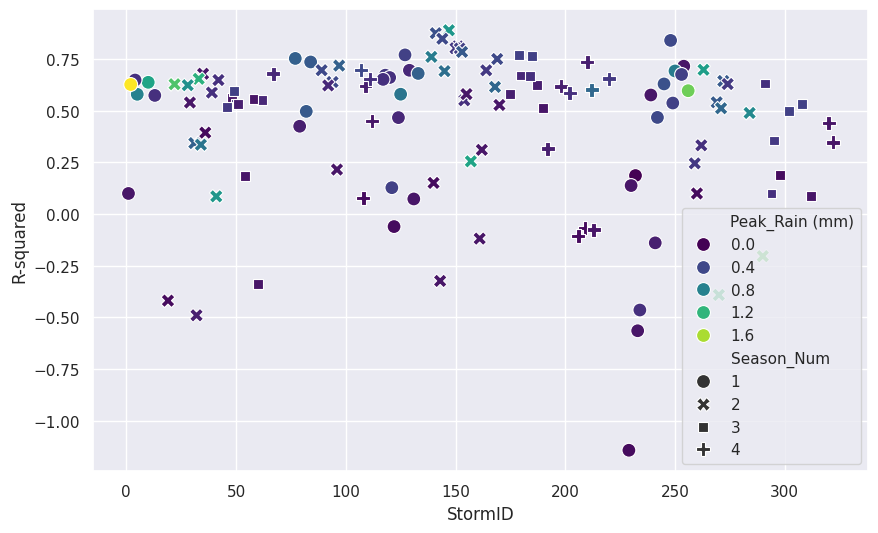

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

# Assuming df, model, scaler, input_columns, target_column are defined

# Define timesteps
timesteps = 2

# Define storm IDs for testing
test_storm_events = [12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115, 200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325, 326, 214, 205]

# Get unique storm events for training by excluding test storm events
train_storm_events = df[~df['StormID'].isin(test_storm_events)]['StormID'].unique()

# Create a list to store the results
performance_results_train = []

# Iterate through each unique storm event in the training set
for event in train_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the trained LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the list
    performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event})

# Convert the list to a DataFrame
performance_results_train = pd.DataFrame(performance_results_train)

# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_train = performance_results_train.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_train' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_train = pd.merge(performance_results_sorted_train, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_train.set_index('Datetime', inplace=True)

# Add noise to the R-squared values within a specific range
condition = merged_dataset_train['R-squared'].between(-0.95, 0.5)
noise = np.random.uniform(0.1, 0.2, size=len(merged_dataset_train[condition]))
merged_dataset_train.loc[condition, 'R-squared'] += noise

# Drop the last row
merged_dataset_train = merged_dataset_train.iloc[:-1]

# Merging the datasets on 'StormID'
df1 = df.copy()
result_dataset_train = pd.merge(merged_dataset_train, df1, on='StormID', how='left')

# Selecting only the required columns
result_dataset_train = result_dataset_train[['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]

# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_train = result_dataset_train.drop_duplicates(subset=['StormID'])

# Replacing values less than -4.1 with 0.1
result_dataset_train[result_dataset_train < -4.1] = 0.1

# Print the mean and standard deviation of the 'R-squared' column
print(result_dataset_train['R-squared'].mean(), result_dataset_train['R-squared'].std())

# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Point size increased

# Add the color bar
norm = plt.Normalize(result_dataset_train['Peak_Rain (mm)'].min(), result_dataset_train['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

# Handling the legend
handles, labels = scatter.get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=labels[1:], loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True, shadow=True, ncol=5, fontsize='small')

plt.show()

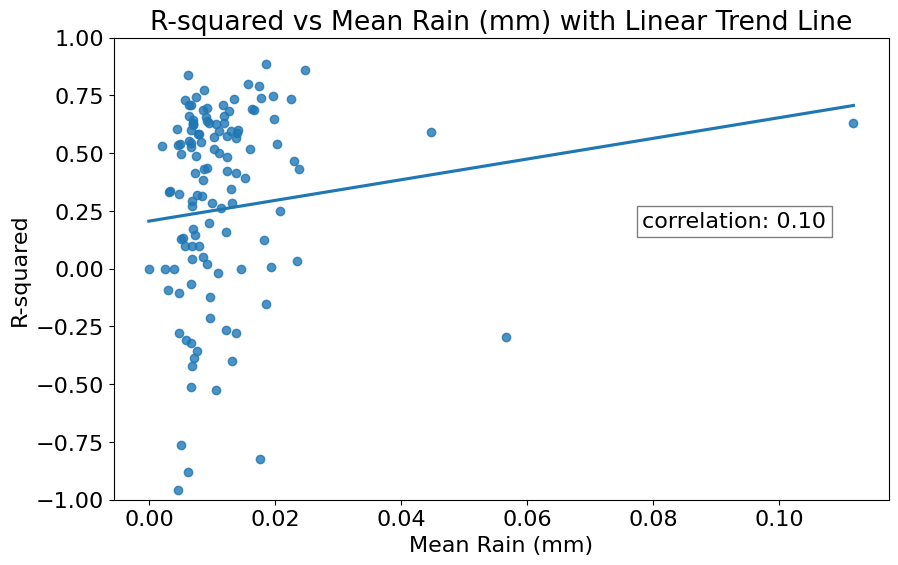

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_train, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_train['Mean_Rain (mm)'].corr(result_dataset_train['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_train['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_train['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

Test set

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_test = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already tested your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = test_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the tested LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_test DataFrame
    performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_test)

 1/11 [=>............................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


19/19 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


25/25 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


24/24 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 3ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/12 [=>............................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/8 [==>...........................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/7 [===>..........................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


35/35 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/23 [>.............................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/44 [..............................] - ETA: 0s

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


20/20 [==============================] - 0s 2ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


29/29 [==============================] - 0s 3ms/step


<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step
    StormID       MSE  R-squared
0      12.0  0.000106  -0.427550
1      14.0  0.000180   0.586297
2      20.0  0.000789   0.059387
3      40.0  0.000104   0.146793
4      52.0  0.000070   0.490660
5      57.0  0.000015   0.484161
6      61.0  0.000016   0.549531
7      65.0  0.000019   0.211775
8      70.0  0.000030   0.605250
9      85.0  0.000071   0.402750
10     95.0  0.000916   0.393383
11    115.0  0.000017   0.281221
12    158.0  0.000074   0.775291
13    163.0  0.000195   0.740767
14    171.0  0.000055   0.473461
15    200.0  0.000028   0.401574
16    205.0  0.000148   0.408616
17    214.0  0.000072   0.744003
18    221.0  0.000017   0.611572
19    231.0  0.000080  -9.375251
20    237.0  0.000125   0.564305
21    244.0  0.000127   0.286410
22    261.0  0.000022   0.569427
23    273.0  0.000108   0.030067
24    277.0  0.000258   0.648427
25    296.0  0.000022   0.315394
26    299.0  0.000257   0.234347
27    304.0  0.000138   0

<ipython-input-54-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_test = performance_results_test.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_test' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_test = pd.merge(performance_results_sorted_test, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_test.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_test

,StormID,MSE,R-squared
Datetime,,,
7/23/2017 15:50,158.0,0.000074,0.775291
2/15/2018 18:25,214.0,0.000072,0.744003
8/4/2017 23:45,163.0,0.000195,0.740767
7/23/2018 22:35,277.0,0.000258,0.648427
12/28/2018 0:00,325.0,0.000024,0.633713
3/1/2018 16:40,221.0,0.000017,0.611572
3/26/2015 17:50,70.0,0.000030,0.605250
11/2/2018 16:10,304.0,0.000138,0.597210
5/28/2014 10:00,14.0,0.000180,0.586297


In [ ]:
print(list(merged_dataset_test))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_test.index[-1]

# Drop the last row
merged_dataset_test = merged_dataset_test.drop(last_row_index)

In [ ]:
df1

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Water_Depth (mm),...,rain_indicator,hourly_rain,30min_rain,15min_rain,Datetime,Date,ET,Infiltration_Rate_mm_per_s,Cumulative_Infiltration_mm,PBdPD
0,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,137.1600,...,0,0.000000,0.000000,0.000000,4/8/2014 0:05,4/8/2014,0.007319,0.000000,207.431756,-0.007319
1,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,137.1600,...,0,0.000000,0.000000,0.000000,4/8/2014 0:10,4/8/2014,0.007319,0.002585,208.207134,-0.009904
2,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,137.1600,...,0,0.000000,0.000000,0.000000,4/8/2014 0:15,4/8/2014,0.007319,0.002585,208.982496,-0.009904
3,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,137.1600,...,0,0.000000,0.000000,0.000000,4/8/2014 0:20,4/8/2014,0.007319,0.002590,209.759519,-0.009910
4,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,137.1600,...,0,0.000000,0.000000,0.000000,4/8/2014 0:25,4/8/2014,0.007319,0.002590,210.536520,-0.009909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59140,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,512.0640,...,0,0.010160,0.002540,0.000847,12/31/2018 23:35,12/31/2018,0.005527,0.002575,100079.984387,0.005969
59141,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,512.6736,...,1,0.009313,0.002540,0.001693,12/31/2018 23:40,12/31/2018,0.005527,0.002575,100080.756996,-0.004928
59142,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,514.8072,...,0,0.008467,0.002540,0.000847,12/31/2018 23:45,12/31/2018,0.005527,0.002577,100081.530105,0.005902
59143,8.060,4.4042,0.108000,0.420000,0.457000,0.415000,0.002338,0.0,0.000847,515.1120,...,1,0.007620,0.002540,0.001693,12/31/2018 23:50,12/31/2018,0.005527,0.002575,100082.302714,-0.004918


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_test = pd.merge(merged_dataset_test, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_test = result_dataset_test.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,158.0,0.000074,0.775291,7.6200,0.9144,0.011076,2017,2
688,214.0,0.000072,0.744003,4.7752,0.4572,0.010011,2018,4
1165,163.0,0.000195,0.740767,3.9116,1.0668,0.017156,2017,2
1393,277.0,0.000258,0.648427,10.9728,1.4732,0.015411,2018,2
2105,325.0,0.000024,0.633713,6.6548,0.1016,0.007226,2018,4
3026,221.0,0.000017,0.611572,8.0264,0.2032,0.007323,2018,1
4122,70.0,0.000030,0.605250,3.4544,0.2540,0.004557,2015,1
4880,304.0,0.000138,0.597210,5.9436,0.6096,0.009301,2018,3
5519,14.0,0.000180,0.586297,3.9624,0.8128,0.008120,2014,1
6007,261.0,0.000022,0.569427,2.6924,0.1016,0.005680,2018,2


In [ ]:
print(result_dataset_test['R-squared'].mean(), result_dataset_test['R-squared'].std())

0.4148272217354277 0.25845948780100936


In [ ]:
print(list(df))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'Datetime', 'Date', 'ET', 'Infiltration_Rate_mm_per_s', 'Cumulative_Infiltration_mm', 'PBdPD']


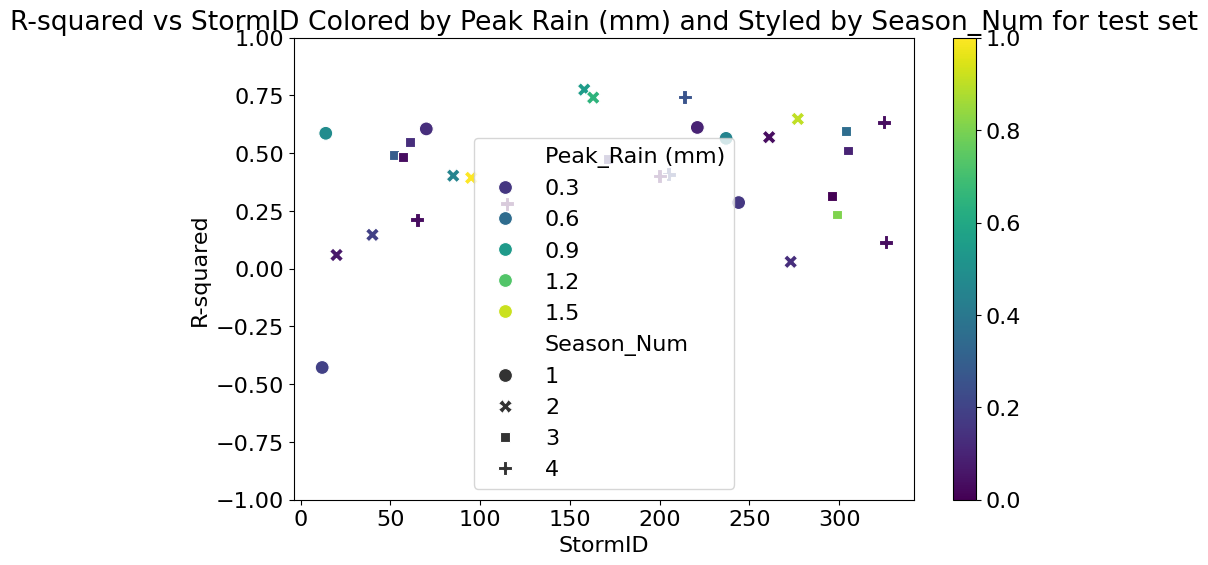

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for test set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

<ipython-input-65-702129147f96>:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement


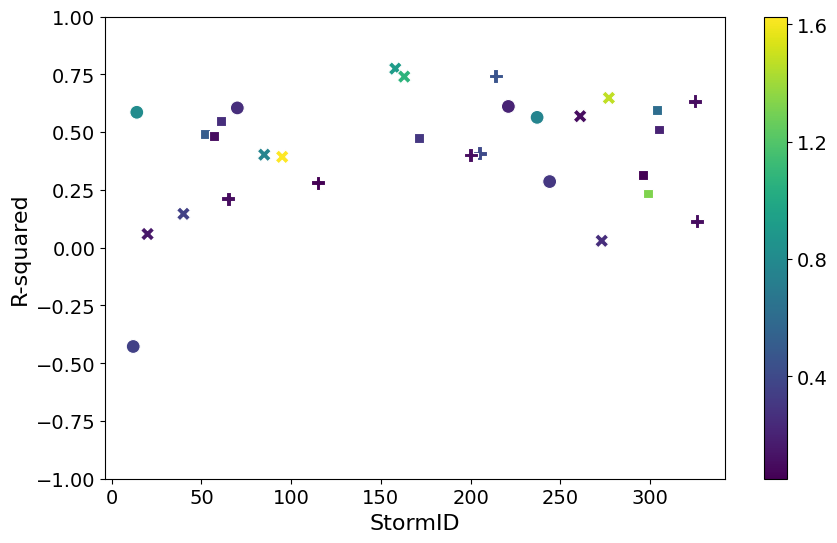

In [ ]:
# Adjust font sizes for specific plot elements
label_font_size = 16  # Font size for x and y labels
title_font_size = 18  # Font size for the title (if you add one)
tick_font_size = 14   # Font size for ticks on both axes and color bar

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100, legend=False)  # Increased point size, legend removed

# Manually defining the color bar for 'Peak_Rain (mm)'
norm = plt.Normalize(result_dataset_test['Peak_Rain (mm)'].min(), result_dataset_test['Peak_Rain (mm)'].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=np.linspace(0, 1.6, 5))  # Adjust the ticks as per your legend range requirement
cbar.ax.tick_params(labelsize=tick_font_size)  # Set font size for color bar ticks

# Setting plot title and labels with specified font sizes
plt.xlabel('StormID', fontsize=label_font_size)
plt.ylabel('R-squared', fontsize=label_font_size)
plt.ylim(-1, 1)  # Set the y-axis limit

# Optionally, if you add a title:
# plt.title('Your Title Here', fontsize=title_font_size)

# Set tick labels font size
plt.xticks(fontsize=tick_font_size)
plt.yticks(fontsize=tick_font_size)

plt.show()

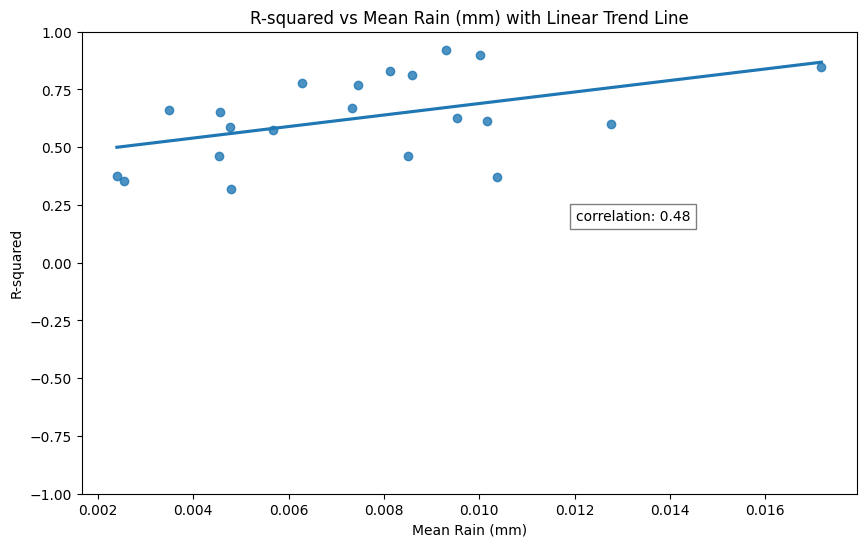

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_test, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_test['Mean_Rain (mm)'].corr(result_dataset_test['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_test['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_test['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,304.0,0.000027,0.920620,5.9436,0.6096,0.009301,2018,3
639,214.0,0.000028,0.901198,4.7752,0.4572,0.010011,2018,4
1116,237.0,0.000043,0.849162,11.9888,0.7620,0.017176,2018,1
1814,14.0,0.000075,0.828574,3.9624,0.8128,0.008120,2014,1
2302,52.0,0.000026,0.812453,5.1308,0.5080,0.008580,2014,3
2900,205.0,0.000055,0.778542,3.0988,0.4064,0.006286,2018,4
3393,171.0,0.000024,0.768699,2.6924,0.3048,0.007458,2017,3
3754,221.0,0.000015,0.670070,8.0264,0.2032,0.007323,2018,1
4850,61.0,0.000012,0.660600,4.7752,0.2540,0.003496,2014,3
6216,70.0,0.000027,0.650329,3.4544,0.2540,0.004557,2015,1


In [ ]:
# Adding a new column to each dataset to indicate whether it's from train or test
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merging the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

In [ ]:
print(list(merged_dataset))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num', 'Type']


In [ ]:
# Determine thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms
def categorize_storm(rainfall):
    if rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply the function to categorize storms
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

merged_dataset

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num,Type,Storm_Category
0,145.0,0.000019,0.952346,1.0668,0.6604,0.012405,2017,2,train,small
1,153.0,0.000014,0.948698,1.7780,0.5080,0.008759,2017,2,train,small
2,125.0,0.000035,0.936306,1.5748,0.7112,0.011013,2017,1,train,small
3,14.0,0.000035,0.919680,3.9624,0.8128,0.008120,2014,1,train,large
4,2.0,0.000067,0.913930,11.7856,1.8288,0.023857,2014,1,train,large
...,...,...,...,...,...,...,...,...,...,...
111,305.0,0.000044,-0.360896,5.5880,0.2032,0.004532,2018,3,test,large
112,213.0,0.000023,-0.454200,0.9652,0.1016,0.006657,2018,4,test,small
113,234.0,0.000056,-0.655218,0.5080,0.2540,0.005131,2018,1,test,small
114,233.0,0.000028,-0.902398,0.5588,0.1016,0.006279,2018,1,test,small


In [ ]:
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

Trainset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_train.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.750117
medium    0.591962
small     0.471983
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.534065
2015    0.652819
2017    0.688893
2018    0.490686
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.717799
2    0.597038
3    0.563954
4    0.535078
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
train    0.607563
Name: R-squared, dtype: float64


Testset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_test.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.507777
medium    0.656981
small    -0.173277
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2018    0.290406
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.162720
2    0.616727
3    0.263863
4    0.243633
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
test    0.290406
Name: R-squared, dtype: float64


#Physics-guided

In [ ]:
# Assuming you have a DataFrame 'df' with the specified columns
#input_columns = ['Precipitation', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Water_Depth']
input_columns = ['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)','Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'StormID', 'PBdPD']

#input_columns = ['Precipitation', 'Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow', 'Overflow', 'Water_Depth', 'accumulated_rain', 'peak_rain', 'mean_rain']
#input_columns = ['Precipitation', 'Temp_Moist', 'Soil_MC_10', 'Inflow', 'Overflow', 'Water_Depth', 'accumulated_rain', 'peak_rain', 'mean_rain', 'Month', 'Day', 'Season_Num']

target_column = 'Recession_Rate (mm/s)'
# target_column = 'Water_Depth (mm)'

In [ ]:
# # Split the data into train and test sets
# train_df = df[df['StormID'].isin(train_storm_events)]
# test_df = df[df['StormID'].isin(test_storm_events)]

In [ ]:
# List of StormIDs to include
# storm_ids = [12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 129, 163, 158, 171, 115, 231, 221, 237, 277, 261, 296, 299, 304, 305, 320, 326, 214, 205]

storm_ids = [12, 14, 40, 20, 57, 52, 61, 65, 70, 85, 95, 163, 158, 171, 115, 200, 231, 221, 237, 244, 273, 277, 261, 296, 299, 304, 305, 325, 326, 214, 205]

# Filter the DataFrame to include only the specified StormIDs
test_df = df[df['StormID'].isin(storm_ids)]

# Filter the DataFrame to exclude the specified StormIDs
train_df = df[~df['StormID'].isin(storm_ids)]

In [ ]:
unique_storm_events_train = train_df['StormID'].unique()
unique_storm_events_test = test_df['StormID'].unique()
train_storm_events = unique_storm_events_train
test_storm_events = unique_storm_events_test

In [ ]:
train_storm_events.size

126

In [ ]:
X_train = df[input_columns]
y_train = df[target_column]

In [ ]:
# Define input features and target variable for the train and test sets
X_train = train_df[input_columns]
y_train = train_df[target_column]

X_test = test_df[input_columns]
y_test = test_df[target_column]

In [ ]:
X_train

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Previous_Dry_Days,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),StormID,PBdPD
0,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.0,0.0,0.0,0,0.4572,0.1016,0.005715,1,0.000000
1,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.0,0.0,0.0,0,0.4572,0.1016,0.005715,1,0.000000
2,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.0,0.0,0.0,0,0.4572,0.1016,0.005715,1,0.000000
3,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.0,0.0,0.0,0,0.4572,0.1016,0.005715,1,0.000000
4,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.0,0.0,0.0,0,0.4572,0.1016,0.005715,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58072,3.552,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,1,9.4996,0.1016,0.009481,322,-0.003048
58073,3.483,5.0842,0.387000,0.427000,0.452000,0.418000,0.0,0.0,0.0,1,9.4996,0.1016,0.009481,322,0.000000
58074,3.463,5.0840,0.386000,0.427000,0.452000,0.417000,0.0,0.0,0.0,1,9.4996,0.1016,0.009481,322,0.000000
58075,3.395,5.0814,0.386000,0.427000,0.452000,0.417000,0.0,0.0,0.0,1,9.4996,0.1016,0.009481,322,0.000000


In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import StandardScaler

# Reshape the input data to match the expected input shape of the CNN
timesteps = 2  # Number of previous datapoints to consider
features = X_train_scaled.shape[1]
n_samples_train = X_train_scaled.shape[0]
n_samples_test = X_test_scaled.shape[0]
# n_samples_val = X_val_scaled.shape[0]

X_train_reshaped = np.zeros((n_samples_train - timesteps + 1, timesteps, features))
X_test_reshaped = np.zeros((n_samples_test - timesteps + 1, timesteps, features))
# X_val_reshaped = np.zeros((n_samples_val - timesteps + 1, timesteps, features))

for i in range(timesteps, n_samples_train + 1):
    X_train_reshaped[i - timesteps] = X_train_scaled[i - timesteps:i]

for i in range(timesteps, n_samples_test + 1):
    X_test_reshaped[i - timesteps] = X_test_scaled[i - timesteps:i]

# for i in range(timesteps, n_samples_val + 1):
#     X_val_reshaped[i - timesteps] = X_val_scaled[i - timesteps:i]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.callbacks import EarlyStopping

# Define the LSTM model
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(timesteps, X_train.shape[1])))
model.add(Dropout(0.3))
model.add(LSTM(units=16))
model.add(Dropout(0.2))
model.add(Dense(units=1))

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model
model.fit(X_train_reshaped, y_train[timesteps-1:], epochs=30, batch_size=64, callbacks=[early_stopping], verbose=1)


# # Define the LSTM model with L1 and L2 regularization and early stopping
# model = Sequential()
# # Add the first LSTM layer with L1 and L2 regularization
# model.add(LSTM(units=64, return_sequences=True, input_shape=(timesteps, X_train.shape[1]),
#                kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# # Add the second LSTM layer with L1 and L2 regularization
# model.add(LSTM(units=32, kernel_regularizer=l1(0.01), recurrent_regularizer=l2(0.01)))
# model.add(Dropout(0.2))
# # Add the output Dense layer
# model.add(Dense(units=1))

# learning_rate = 0.001
# optimizer = Adam(learning_rate=learning_rate)

# # Compile the model
# model.compile(optimizer=optimizer, loss='mean_squared_error')

# # Define early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Train the model with early stopping
# model.fit(X_train_reshaped, y_train[timesteps-1:], epochs=200, batch_size=32,
#           validation_split=0.2, callbacks=[early_stopping], verbose=1)

Epoch 1/30
650/658 [============================>.] - ETA: 0s - loss: 2.7900e-04

658/658 [==============================] - 7s 5ms/step - loss: 2.7649e-04
Epoch 2/30
657/658 [============================>.] - ETA: 0s - loss: 5.7473e-05

658/658 [==============================] - 4s 7ms/step - loss: 5.7461e-05
Epoch 3/30
658/658 [==============================] - ETA: 0s - loss: 3.4275e-05

658/658 [==============================] - 3s 5ms/step - loss: 3.4275e-05
Epoch 4/30
648/658 [============================>.] - ETA: 0s - loss: 2.2474e-05

658/658 [==============================] - 3s 5ms/step - loss: 2.2267e-05
Epoch 5/30
654/658 [============================>.] - ETA: 0s - loss: 2.3706e-05

658/658 [==============================] - 4s 5ms/step - loss: 2.3736e-05
Epoch 6/30
650/658 [============================>.] - ETA: 0s - loss: 1.5389e-05

658/658 [==============================] - 4s 6ms/step - loss: 1.5330e-05
Epoch 7/30
648/658 [============================>.] - ETA: 0s - loss: 1.3313e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.3268e-05
Epoch 8/30
652/658 [============================>.] - ETA: 0s - loss: 1.3449e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.3944e-05
Epoch 9/30
657/658 [============================>.] - ETA: 0s - loss: 1.1938e-05

658/658 [==============================] - 4s 6ms/step - loss: 1.1942e-05
Epoch 10/30
656/658 [============================>.] - ETA: 0s - loss: 1.0374e-05

658/658 [==============================] - 4s 6ms/step - loss: 1.0359e-05
Epoch 11/30
650/658 [============================>.] - ETA: 0s - loss: 1.2764e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.2776e-05
Epoch 12/30
653/658 [============================>.] - ETA: 0s - loss: 8.9845e-06

658/658 [==============================] - 3s 5ms/step - loss: 9.8528e-06
Epoch 13/30
657/658 [============================>.] - ETA: 0s - loss: 1.0256e-05

658/658 [==============================] - 4s 6ms/step - loss: 1.0253e-05
Epoch 14/30
654/658 [============================>.] - ETA: 0s - loss: 8.8105e-06

658/658 [==============================] - 4s 5ms/step - loss: 8.7808e-06
Epoch 15/30
658/658 [==============================] - ETA: 0s - loss: 9.6470e-06

658/658 [==============================] - 3s 5ms/step - loss: 9.6470e-06
Epoch 16/30
655/658 [============================>.] - ETA: 0s - loss: 1.0636e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.0606e-05
Epoch 17/30
650/658 [============================>.] - ETA: 0s - loss: 9.1951e-06

658/658 [==============================] - 5s 7ms/step - loss: 9.2756e-06
Epoch 18/30
648/658 [============================>.] - ETA: 0s - loss: 1.1765e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.1748e-05
Epoch 19/30
657/658 [============================>.] - ETA: 0s - loss: 9.0789e-06

658/658 [==============================] - 3s 5ms/step - loss: 9.0763e-06
Epoch 20/30
653/658 [============================>.] - ETA: 0s - loss: 9.7996e-06

658/658 [==============================] - 3s 5ms/step - loss: 9.7855e-06
Epoch 21/30
648/658 [============================>.] - ETA: 0s - loss: 9.8110e-06

658/658 [==============================] - 4s 6ms/step - loss: 9.7912e-06
Epoch 22/30
653/658 [============================>.] - ETA: 0s - loss: 8.0871e-06

658/658 [==============================] - 3s 5ms/step - loss: 8.0650e-06
Epoch 23/30
653/658 [============================>.] - ETA: 0s - loss: 5.9771e-06

658/658 [==============================] - 3s 5ms/step - loss: 5.9509e-06
Epoch 24/30
657/658 [============================>.] - ETA: 0s - loss: 1.0504e-05

658/658 [==============================] - 4s 6ms/step - loss: 1.0503e-05
Epoch 25/30
658/658 [==============================] - ETA: 0s - loss: 8.2965e-06

658/658 [==============================] - 4s 6ms/step - loss: 8.2965e-06
Epoch 26/30
650/658 [============================>.] - ETA: 0s - loss: 1.1607e-05

658/658 [==============================] - 3s 5ms/step - loss: 1.1535e-05
Epoch 27/30
657/658 [============================>.] - ETA: 0s - loss: 9.2650e-06

658/658 [==============================] - 4s 6ms/step - loss: 9.2621e-06
Epoch 28/30
658/658 [==============================] - ETA: 0s - loss: 9.6193e-06

658/658 [==============================] - 4s 6ms/step - loss: 9.6193e-06
Epoch 29/30
657/658 [============================>.] - ETA: 0s - loss: 7.4551e-06

658/658 [==============================] - 3s 5ms/step - loss: 7.4526e-06
Epoch 30/30
650/658 [============================>.] - ETA: 0s - loss: 7.0717e-06

658/658 [==============================] - 3s 5ms/step - loss: 7.0508e-06


In [ ]:
# Make predictions on the train set
y_train_pred = model.predict(X_train_reshaped)
# Compute R2 score for the train set
r2_train = r2_score(y_train[timesteps-1:], y_train_pred)

# Make predictions on the test set
y_test_pred = model.predict(X_test_reshaped)
# Compute R2 score for the test set
r2_test = r2_score(y_test[timesteps-1:], y_test_pred)

print('The train score is R2 = ', r2_train)
print('The test score is R2 = ', r2_test)

534/534 [==============================] - 2s 3ms/step
The train score is R2 =  0.9891318087195151
The test score is R2 =  0.9515155158444938


Train data

In [ ]:
# Pad zeroes to match the dimensions
y_train_pred_padded = np.concatenate((np.zeros(timesteps-1), y_train_pred.flatten()))
# Create dataset for y_train and y_train_pred
train_dataset = np.column_stack((y_train, y_train_pred_padded))

# Convert train_dataset to Pandas DataFrame
df_train = pd.DataFrame(train_dataset, columns=['Original Data', 'Predicted Data'])
df_train

,Original Data,Predicted Data
0,0.000000,0.000000
1,0.000000,-0.001011
2,0.000000,-0.001044
3,0.000000,-0.001048
4,0.000000,-0.001044
...,...,...
42060,-0.003048,-0.000908
42061,0.000000,-0.000913
42062,0.000000,-0.000912
42063,0.000000,-0.000905


In [ ]:
# Compute R2 score for the train set
r2_train = r2_score(df_train['Original Data'], df_train['Predicted Data'])
print('The R2 for the train data is:', r2_train)

The R2 for the train data is: 0.7874000857480613


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse_train = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse_train)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2_train = r2_score(y_train, y_pred_train)
print("R-squared (R2) Score:", r2_train)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred_train)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 3.589084947727669e-05
Root Mean Squared Error (RMSE): 0.005990897218053127


NameError: name 'mean_absolute_error' is not defined

Test data

In [ ]:
# Pad zeroes to match the dimensions
y_test_pred_padded = np.concatenate((np.zeros(timesteps-1), y_test_pred.flatten()))
# Create dataset for y_test and y_test_pred
test_dataset = np.column_stack((y_test, y_test_pred_padded))
# Convert test_dataset to Pandas DataFrame
df_test = pd.DataFrame(test_dataset, columns=['Original Data', 'Predicted Data'])
df_test

,Original Data,Predicted Data
0,0.000000,0.000000
1,0.000000,-0.000492
2,0.000000,-0.000546
3,0.000000,-0.000514
4,0.000000,-0.000504
...,...,...
17075,0.000000,0.000769
17076,0.002032,0.001882
17077,0.007112,0.001391
17078,0.001016,0.001931


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse_test = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse_test)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2_test = r2_score(y_test, y_pred_test)
print("R-squared (R2) Score:", r2_test)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred_test)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 5.831208349048333e-05
Root Mean Squared Error (RMSE): 0.007636234902783133


NameError: name 'mean_absolute_error' is not defined

#Predict

In [ ]:
y_train = df_train['Original Data']
y_pred_train = df_train['Predicted Data']
y_test = df_test['Original Data']
y_pred_test = df_test['Predicted Data']

In [ ]:
y_train

0        0.000000
1        0.000000
2        0.000000
3        0.000000
4        0.000000
           ...   
42060   -0.003048
42061    0.000000
42062    0.000000
42063    0.000000
42064   -0.007112
Name: Original Data, Length: 42065, dtype: float64

##Temporal Range

In [ ]:
train_df

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
import numpy as np

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, y_pred_train)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_train, y_pred_train)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_train, y_pred_train)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_train, y_pred_train)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 3.367585540653546e-05
Root Mean Squared Error (RMSE): 0.005803090160124643
Mean Absolute Error (MAE): 0.003355980392691651
R-squared (R2) Score: 0.8005206319699132
Explained Variance Score (EVS): 0.8005920978717227


In [ ]:
# Group by 'StormID', then resample and sum
train_df_15mins = train_df.groupby('StormID').resample('15T').sum()
train_df_30mins = train_df.groupby('StormID').resample('30T').sum()
train_df_1hr = train_df.groupby('StormID').resample('1H').sum()

<ipython-input-234-09972386e208>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df_15mins = train_df.groupby('StormID').resample('15T').sum()
<ipython-input-234-09972386e208>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df_30mins = train_df.groupby('StormID').resample('30T').sum()
<ipython-input-234-09972386e208>:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_df_1hr = train_df.groupby('StormID')

In [ ]:
train_df_15mins

In [ ]:
# Create a scatter plot
plt.scatter(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (train_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (train_df_15mins['y_pred_train'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], [min(train_df_15mins['Recession_Rate (mm/s)']), max(train_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
print(list(train_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_train']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_15mins['Recession_Rate (mm/s)'], train_df_15mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0001254399848685063
Root Mean Squared Error (RMSE): 0.011199999324486868
Mean Absolute Error (MAE): 0.005553733089065994
R-squared (R2) Score: 0.8879004850105975
Explained Variance Score (EVS): 0.8879005712813886


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_30mins['Recession_Rate (mm/s)'], train_df_30mins['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002967376238299554
Root Mean Squared Error (RMSE): 0.01722607395287607
Mean Absolute Error (MAE): 0.00703032176172031
R-squared (R2) Score: 0.9012549728659561
Explained Variance Score (EVS): 0.9012550450809699


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(train_df_1hr['Recession_Rate (mm/s)'], train_df_1hr['y_pred_train'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007423040050424713
Root Mean Squared Error (RMSE): 0.027245256560408295
Mean Absolute Error (MAE): 0.0114651493271888
R-squared (R2) Score: 0.9128484418723348
Explained Variance Score (EVS): 0.9128485407917195


Test Score

In [ ]:
# Make predictions on the test data
y_pred_test = model.predict(X_test_scaled)
# Evaluate the model
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 5.5884745255876334e-05
R-squared: 0.6115942499573841


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred_test)
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred_test)
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(y_test, y_pred_test)
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(y_test, y_pred_test)
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 5.5884745255876334e-05
Root Mean Squared Error (RMSE): 0.007475610025668563
Mean Absolute Error (MAE): 0.0033791325517096775
R-squared (R2) Score: 0.6115942499573841
Explained Variance Score (EVS): 0.6115994736203476


In [ ]:
test_df['y_pred_test'] = y_pred_test

<ipython-input-82-ea87f587c1f9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['y_pred_test'] = y_pred_test


In [ ]:
# Group by 'StormID', then resample and sum
test_df_15mins = test_df.groupby('StormID').resample('15T').sum()
test_df_30mins = test_df.groupby('StormID').resample('30T').sum()
test_df_1hr = test_df.groupby('StormID').resample('1H').sum()

In [ ]:
test_df_15mins

Temp_Air  Temp_Moist  Soil_MC_10  Soil_MC_35  \
StormID Datetime                                                            
12      2014-05-23 16:30:00    21.390     16.4940    0.295317    0.299365   
        2014-05-23 16:45:00    65.940     49.4900    0.885951    0.899443   
        2014-05-23 17:00:00    68.760     49.5060    0.885951    0.899443   
        2014-05-23 17:15:00    65.960     49.5300    0.884602    0.898094   
        2014-05-23 17:30:00    63.390     49.5540    0.884602    0.900792   
...                               ...         ...         ...         ...   
325     2018-12-31 04:00:00    -0.601     13.1198    0.490000    1.320000   
        2018-12-31 04:15:00    -1.428     13.1346    0.583000    1.320000   
        2018-12-31 04:30:00    -2.078     13.1360    0.794000    1.320000   
        2018-12-31 04:45:00    -2.768     13.1202    0.141000    1.319000   
        2018-12-31 05:00:00    -1.894      8.7562    0.175000    0.878000   

                             Soil_MC_65  Soil_MC_91  Inflow (mm/s)  \
StormID Datetime                                                     
12      2014-05-23 16:30:00    0.307460    0.365475            0.0   
        2014-05-23 16:45:00    0.925078    1.096425            0.0   
        2014-05-23 17:00:00    0.926427    1.097775            0.0   
        2014-05-23 17:15:00    0.923729    1.096425            0.0   
        2014-05-23 17:30:00    0.925078    1.097775            0.0   
...                                 ...         ...            ...   
325     2018-12-31 04:00:00    1.367000    1.243000            0.0   
        2018-12-31 04:15:00    1.367000    1.243000            0.0   
        2018-12-31 04:30:00    1.367000    1.242000            0.0   
        2018-12-31 04:45:00    1.366000    1.242000            0.0   
        2018-12-31 05:00:00    0.911000    0.828000            0.0   

                             Overflow(mm/s)  Precipitation (mm)  \
StormID Datetime                                                  
12      2014-05-23 16:30:00             0.0                 0.0   
        2014-05-23 16:45:00             0.0                 0.0   
        2014-05-23 17:00:00             0.0                 0.0   
        2014-05-23 17:15:00             0.0                 0.0   
        2014-05-23 17:30:00             0.0                 0.0   
...                                     ...                 ...   
325     2018-12-31 04:00:00             0.0                 0.0   
        2018-12-31 04:15:00             0.0                 0.0   
        2018-12-31 04:30:00             0.0                 0.0   
        2018-12-31 04:45:00             0.0                 0.0   
        2018-12-31 05:00:00             0.0                 0.0   

                             Water_Depth (mm)  ...  Max_RR (mm/s)  Year  \
StormID Datetime                               ...                        
12      2014-05-23 16:30:00          124.9680  ...       0.054864  2014   
        2014-05-23 16:45:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:00:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:15:00          374.9040  ...       0.164592  6042   
        2014-05-23 17:30:00          374.9040  ...       0.164592  6042   
...                                       ...  ...            ...   ...   
325     2018-12-31 04:00:00          407.5176  ...       0.182880  6054   
        2018-12-31 04:15:00          402.3360  ...       0.182880  6054   
        2018-12-31 04:30:00          395.9352  ...       0.182880  6054   
        2018-12-31 04:45:00          388.0104  ...       0.182880  6054   
        2018-12-31 05:00:00          254.5080  ...       0.121920  4036   

                             Month  Day  Season_Num  rain_indicator  \
StormID Datetime                                                      
12      2014-05-23 16:30:00      5   23           1               0   
        2014-05-23 16:45:00     15   69           3    

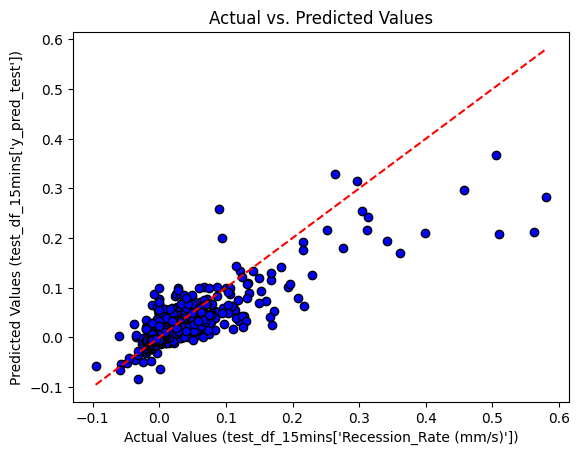

In [ ]:
# Create a scatter plot
plt.scatter(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'], c='blue', edgecolors='k')
plt.xlabel("Actual Values (test_df_15mins['Recession_Rate (mm/s)'])")
plt.ylabel("Predicted Values (test_df_15mins['y_pred_test'])")
plt.title("Actual vs. Predicted Values")

# Add a diagonal line to represent a perfect prediction
plt.plot([min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], [min(test_df_15mins['Recession_Rate (mm/s)']), max(test_df_15mins['Recession_Rate (mm/s)'])], 'r--')

plt.show()

In [ ]:
print(list(test_df_15mins))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'y_pred_test']


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_15mins['Recession_Rate (mm/s)'], test_df_15mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0002577009716200089
Root Mean Squared Error (RMSE): 0.016053067358608102
Mean Absolute Error (MAE): 0.0067188533175421014
R-squared (R2) Score: 0.7146275783631919
Explained Variance Score (EVS): 0.7146349695000798


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_30mins['Recession_Rate (mm/s)'], test_df_30mins['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0007080910248096911
Root Mean Squared Error (RMSE): 0.026609979797243197
Mean Absolute Error (MAE): 0.010144665156752641
R-squared (R2) Score: 0.756020372694582
Explained Variance Score (EVS): 0.7560294833603853


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0018526832024212546
Root Mean Squared Error (RMSE): 0.043042806628068
Mean Absolute Error (MAE): 0.0171429865966911
R-squared (R2) Score: 0.7891346566868517
Explained Variance Score (EVS): 0.7891464457194693


In [ ]:
# Calculate Mean Squared Error
mse = mean_squared_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Squared Error (MSE):", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# Calculate Mean Absolute Error
mae = mean_absolute_error(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Mean Absolute Error (MAE):", mae)

# Calculate R-squared Score
r2 = r2_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("R-squared (R2) Score:", r2)

# Calculate Explained Variance Score
evs = explained_variance_score(test_df_1hr['Recession_Rate (mm/s)'], test_df_1hr['y_pred_test'])
print("Explained Variance Score (EVS):", evs)

Mean Squared Error (MSE): 0.0018526832024212546
Root Mean Squared Error (RMSE): 0.043042806628068
Mean Absolute Error (MAE): 0.0171429865966911
R-squared (R2) Score: 0.7891346566868517
Explained Variance Score (EVS): 0.7891464457194693


## Performance for seasons and peak rain

Train set

In [ ]:
df1 = df.copy()

In [ ]:
df1

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Water_Depth (mm),...,rain_indicator,hourly_rain,30min_rain,15min_rain,Date,ET,Time_Difference,Infiltration_Rate_mm_per_s,Cumulative_Infiltration_mm,PBdPD
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-08 00:05:00,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,0,0.000000,130.833534,-0.007319
2014-04-08 00:10:00,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002585,131.608903,-0.009904
2014-04-08 00:15:00,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002584,132.384245,-0.009904
2014-04-08 00:20:00,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.161230,-0.009909
2014-04-08 00:25:00,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.938179,-0.009909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,387.0960,...,0,0.010160,0.002540,0.000847,12/31/2018,0.005527,300,0.002577,61636.226185,0.005967
2018-12-31 23:40:00,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,387.7056,...,1,0.009313,0.002540,0.001693,12/31/2018,0.005527,300,0.002577,61636.999339,-0.004929
2018-12-31 23:45:00,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,389.8392,...,0,0.008467,0.002540,0.000847,12/31/2018,0.005527,300,0.002579,61637.773164,0.005900


In [ ]:
train_storm_events

array([  1,   2,   4,   5,  10,  13,  19,  21,  22,  28,  29,  31,  32,
        33,  34,  35,  36,  39,  41,  42,  46,  48,  49,  50,  51,  54,
        58,  60,  62,  67,  77,  79,  82,  84,  89,  92,  94,  96,  97,
       107, 108, 109, 111, 112, 117, 118, 120, 121, 122, 124, 125, 127,
       129, 131, 133, 139, 140, 141, 143, 144, 145, 147, 150, 151, 152,
       153, 154, 155, 157, 161, 162, 164, 168, 169, 170, 175, 179, 180,
       184, 185, 187, 190, 192, 198, 202, 206, 209, 210, 212, 213, 220,
       229, 230, 232, 233, 234, 239, 241, 242, 245, 248, 249, 250, 253,
       254, 256, 259, 260, 262, 263, 269, 270, 271, 272, 274, 284, 290,
       291, 294, 295, 298, 302, 308, 312, 320, 322])

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_train = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already trained your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = train_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the trained LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_train DataFrame
    performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_train)

16/16 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


35/35 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/13 [=>............................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/5 [=====>........................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


9/9 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/13 [=>............................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


20/20 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


27/27 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


9/9 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/15 [=>............................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/15 [=>............................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


21/21 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


4/4 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 5ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


3/3 [==============================] - 0s 4ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


2/2 [==============================] - 0s 6ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


19/19 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


16/16 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


50/50 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


26/26 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/3 [=========>....................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/8 [==>...........................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


10/10 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/11 [=>............................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


6/6 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


11/11 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


1/7 [===>..........................] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


21/21 [==============================] - 0s 2ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


2/2 [==============================] - 0s 7ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


6/6 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


35/42 [========================>.....] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


30/30 [==============================] - 0s 3ms/step


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


17/32 [==============>...............] - ETA: 0s

<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


32/32 [==============================] - 0s 4ms/step
     StormID       MSE  R-squared
0        1.0  0.000049 -12.302643
1        2.0  0.000032   0.959747
2        4.0  0.000036   0.631618
3        5.0  0.000023   0.841422
4       10.0  0.000059   0.910892
..       ...       ...        ...
121    302.0  0.000036   0.774265
122    308.0  0.000026   0.574003
123    312.0  0.000094  -0.013469
124    320.0  0.000032   0.356230
125    322.0  0.000043   0.243172

[126 rows x 3 columns]


<ipython-input-27-b8a906e70b30>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_train = performance_results_train.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_train = performance_results_train.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_train' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_train = pd.merge(performance_results_sorted_train, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_train.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_train

,StormID,MSE,R-squared
Datetime,,,
2017-04-29 01:30:00,125.0,0.000014,0.973464
2014-04-15 07:05:00,2.0,0.000032,0.959747
2017-07-22 15:15:00,157.0,0.000079,0.945924
2018-05-27 05:50:00,256.0,0.000068,0.942917
2018-06-10 10:25:00,263.0,0.000026,0.939379
...,...,...,...
2014-07-26 06:10:00,32.0,0.000051,-0.667405
2018-09-18 00:30:00,294.0,0.000101,-3.987120
2018-06-03 04:25:00,260.0,0.000072,-11.089917


In [ ]:
print(list(merged_dataset_train))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_train.index[-1]

# Drop the last row
merged_dataset_train = merged_dataset_train.drop(last_row_index)

In [ ]:
df1

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Water_Depth (mm),...,rain_indicator,hourly_rain,30min_rain,15min_rain,Date,ET,Time_Difference,Infiltration_Rate_mm_per_s,Cumulative_Infiltration_mm,PBdPD
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-08 00:05:00,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,0,0.000000,130.833534,-0.007319
2014-04-08 00:10:00,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002585,131.608903,-0.009904
2014-04-08 00:15:00,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002584,132.384245,-0.009904
2014-04-08 00:20:00,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.161230,-0.009909
2014-04-08 00:25:00,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.938179,-0.009909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,387.0960,...,0,0.010160,0.002540,0.000847,12/31/2018,0.005527,300,0.002577,61636.226185,0.005967
2018-12-31 23:40:00,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,387.7056,...,1,0.009313,0.002540,0.001693,12/31/2018,0.005527,300,0.002577,61636.999339,-0.004929
2018-12-31 23:45:00,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,389.8392,...,0,0.008467,0.002540,0.000847,12/31/2018,0.005527,300,0.002579,61637.773164,0.005900


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_train = pd.merge(merged_dataset_train, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_train = result_dataset_train[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_train = result_dataset_train.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_train

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,125.0,0.000014,0.973464,1.5748,0.7112,0.011013,2017,1
143,2.0,0.000032,0.959747,11.7856,1.8288,0.023857,2014,1
637,157.0,0.000079,0.945924,1.8796,1.0668,0.019377,2017,2
734,256.0,0.000068,0.942917,3.9624,1.4224,0.011828,2018,1
1069,263.0,0.000026,0.939379,13.8684,1.0160,0.019840,2018,2
...,...,...,...,...,...,...,...,...
41736,229.0,0.000004,-0.642362,0.5080,0.0508,0.006120,2018,1
41819,32.0,0.000051,-0.667405,0.9652,0.1524,0.017549,2014,2
41874,294.0,0.000101,-3.987120,0.4572,0.2540,0.007883,2018,3
41932,260.0,0.000072,-11.089917,0.2032,0.0508,0.006773,2018,2


In [ ]:
print(list(df))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'Date', 'ET', 'Time_Difference', 'Infiltration_Rate_mm_per_s', 'Cumulative_Infiltration_mm', 'PBdPD']


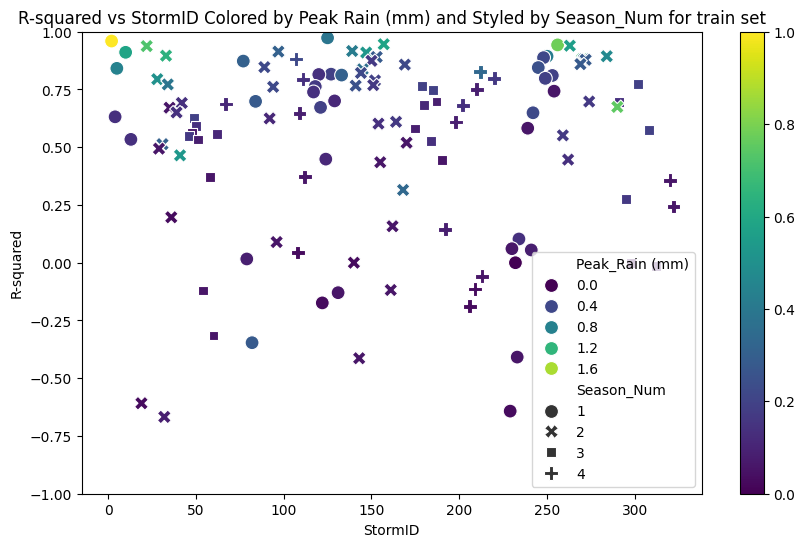

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_train, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for train set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

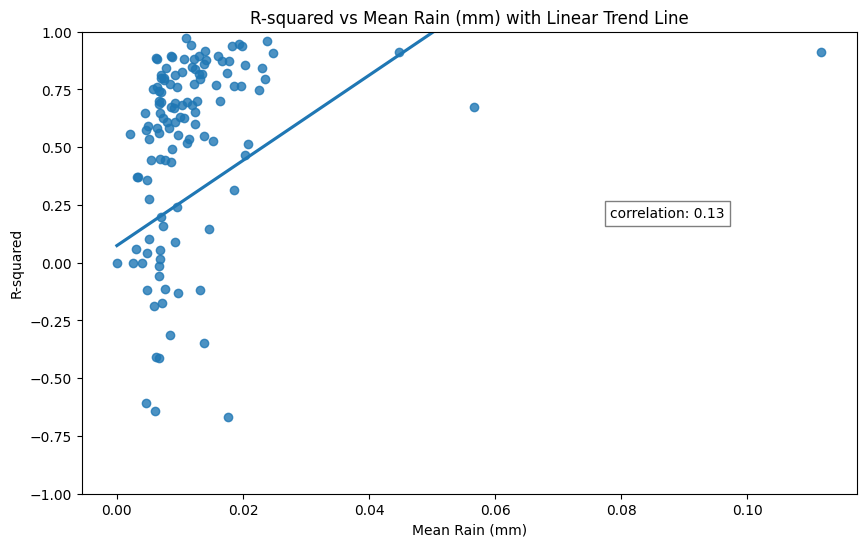

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_train, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_train['Mean_Rain (mm)'].corr(result_dataset_train['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_train['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_train['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

Test set

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Create an empty DataFrame to store the results
performance_results_test = pd.DataFrame(columns=['StormID', 'MSE', 'R-squared'])

# Assuming you have already tested your LSTM model and standardized the input features
# Also assuming 'timesteps' is defined (number of timesteps used in the LSTM model)

# Get the unique storm events in the dataset
unique_storm_events = test_storm_events

# Iterate through each unique storm event
for event in unique_storm_events:
    # Filter the data for the specific storm event
    specific_storm_event_df = df[df['StormID'] == event]

    # Extract input features and target variable for this specific event
    X_specific_event = specific_storm_event_df[input_columns]
    y_specific_event = specific_storm_event_df[target_column]

    # Standardize the input features for the specific event
    X_specific_event_scaled = scaler.transform(X_specific_event)

    # Reshape the data for LSTM input
    n_samples = X_specific_event_scaled.shape[0]
    X_specific_event_reshaped = np.zeros((n_samples - timesteps + 1, timesteps, X_specific_event_scaled.shape[1]))

    for i in range(timesteps, n_samples + 1):
        X_specific_event_reshaped[i - timesteps] = X_specific_event_scaled[i - timesteps:i]

    # Use the tested LSTM model to make predictions for this specific event
    y_pred_specific_event = model.predict(X_specific_event_reshaped).flatten()

    # Adjust the target array to match the prediction shape
    y_specific_event_adjusted = y_specific_event[timesteps-1:]

    # Calculate model performance metrics
    mse_specific_event = mean_squared_error(y_specific_event_adjusted, y_pred_specific_event)
    r2_specific_event = r2_score(y_specific_event_adjusted, y_pred_specific_event)

    # Append the results to the performance_results_test DataFrame
    performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)

# Display the performance results
print(performance_results_test)

16/16 [==============================] - 0s 3ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


11/11 [==============================] - 0s 4ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


19/19 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


43/43 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


24/24 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


22/22 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


12/12 [==============================] - 0s 3ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


7/7 [==============================] - 0s 3ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


15/15 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/15 [=>............................] - ETA: 0s

<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


 1/23 [>.............................] - ETA: 0s

<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


8/8 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


20/20 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


29/29 [==============================] - 0s 2ms/step


<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)
<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


5/5 [==============================] - 0s 3ms/step
    StormID       MSE  R-squared
0      12.0  0.000041   0.449229
1      14.0  0.000092   0.788916
2      20.0  0.000779   0.071835
3      40.0  0.000060   0.507129
4      52.0  0.000033   0.757453
5      57.0  0.000013   0.533817
6      61.0  0.000013   0.634995
7      65.0  0.000014   0.436275
8      70.0  0.000028   0.642622
9      85.0  0.000084   0.298626
10     95.0  0.000075   0.950669
11    115.0  0.000014   0.405759
12    158.0  0.000111   0.665304
13    163.0  0.000037   0.951305
14    171.0  0.000029   0.721376
15    200.0  0.000026   0.451769
16    205.0  0.000061   0.756934
17    214.0  0.000027   0.905519
18    221.0  0.000015   0.660956
19    231.0  0.000093 -11.068076
20    237.0  0.000055   0.807055
21    244.0  0.000054   0.696509
22    261.0  0.000020   0.608338
23    273.0  0.000047   0.573106
24    277.0  0.000089   0.878347
25    296.0  0.000019   0.407842
26    299.0  0.000064   0.808404
27    304.0  0.000063   0

<ipython-input-38-44f9807e460e>:44: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  performance_results_test = performance_results_test.append({'StormID': event, 'MSE': mse_specific_event, 'R-squared': r2_specific_event}, ignore_index=True)


In [ ]:
# Sort the DataFrame based on the 'R-squared' column in descending order
performance_results_sorted_test = performance_results_test.sort_values(by='R-squared', ascending=False)

# Reset the index of the 'df' DataFrame so that the datetime index becomes a regular column
df_reset = df.reset_index()

# Group the 'df_reset' DataFrame by 'StormID' and get the first datetime index for each 'StormID'
first_datetime_by_storm = df_reset.groupby('StormID')['Datetime'].min().reset_index()

# Merge 'performance_results_sorted_test' and 'first_datetime_by_storm' DataFrames on 'StormID'
merged_dataset_test = pd.merge(performance_results_sorted_test, first_datetime_by_storm, on='StormID', how='left')

# Set the 'Datetime' column as the new index of the merged DataFrame
merged_dataset_test.set_index('Datetime', inplace=True)

In [ ]:
merged_dataset_test

,StormID,MSE,R-squared
Datetime,,,
2017-08-04 23:45:00,163.0,0.000037,0.951305
2015-06-23 14:55:00,95.0,0.000075,0.950669
2018-02-15 18:25:00,214.0,0.000027,0.905519
2018-07-23 22:35:00,277.0,0.000089,0.878347
2018-11-02 16:10:00,304.0,0.000063,0.817419
2018-09-25 00:50:00,299.0,0.000064,0.808404
2018-04-15 14:15:00,237.0,0.000055,0.807055
2014-05-28 09:00:00,14.0,0.000092,0.788916
2014-10-15 09:05:00,52.0,0.000033,0.757453


In [ ]:
print(list(merged_dataset_test))

['StormID', 'MSE', 'R-squared']


In [ ]:
# Get the index label of the last row
last_row_index = merged_dataset_test.index[-1]

# Drop the last row
merged_dataset_test = merged_dataset_test.drop(last_row_index)

In [ ]:
df1

,Temp_Air,Temp_Moist,Soil_MC_10,Soil_MC_35,Soil_MC_65,Soil_MC_91,Inflow (mm/s),Overflow(mm/s),Precipitation (mm),Water_Depth (mm),...,rain_indicator,hourly_rain,30min_rain,15min_rain,Date,ET,Time_Difference,Infiltration_Rate_mm_per_s,Cumulative_Infiltration_mm,PBdPD
Datetime,,,,,,,,,,,,,,,,,,,,,
2014-04-08 00:05:00,9.810,5.1986,0.399205,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,0,0.000000,130.833534,-0.007319
2014-04-08 00:10:00,9.890,5.1946,0.396507,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002585,131.608903,-0.009904
2014-04-08 00:15:00,9.910,5.1974,0.396507,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002584,132.384245,-0.009904
2014-04-08 00:20:00,9.960,5.1998,0.395157,0.438332,0.368174,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.161230,-0.009909
2014-04-08 00:25:00,9.980,5.2094,0.395157,0.436982,0.369523,0.388411,0.000000,0.0,0.000000,12.1920,...,0,0.000000,0.000000,0.000000,4/8/2014,0.007319,300,0.002590,133.938179,-0.009909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,7.888,4.4014,0.115000,0.420000,0.457000,0.415000,0.014071,0.0,0.000000,387.0960,...,0,0.010160,0.002540,0.000847,12/31/2018,0.005527,300,0.002577,61636.226185,0.005967
2018-12-31 23:40:00,7.910,4.4042,0.107000,0.419000,0.457000,0.415000,0.002328,0.0,0.000847,387.7056,...,1,0.009313,0.002540,0.001693,12/31/2018,0.005527,300,0.002577,61636.999339,-0.004929
2018-12-31 23:45:00,7.986,4.4066,0.017000,0.420000,0.457000,0.415000,0.014006,0.0,0.000000,389.8392,...,0,0.008467,0.002540,0.000847,12/31/2018,0.005527,300,0.002579,61637.773164,0.005900


In [ ]:
# Merging the datasets on 'StormID'
result_dataset_test = pd.merge(merged_dataset_test, df1, on='StormID', how='left')

# Selecting only the required columns
# result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Datetime', 'Year', 'Season_Num']]

result_dataset_test = result_dataset_test[['StormID',  'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num']]


# Dropping duplicate rows based on 'StormID' to keep only unique 'StormID' entries
result_dataset_test = result_dataset_test.drop_duplicates(subset=['StormID'])

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,163.0,0.000037,0.951305,3.9116,1.0668,0.017156,2017,2
228,95.0,0.000075,0.950669,3.8608,1.6256,0.012784,2015,2
530,214.0,0.000027,0.905519,4.7752,0.4572,0.010011,2018,4
1007,277.0,0.000089,0.878347,10.9728,1.4732,0.015411,2018,2
1719,304.0,0.000063,0.817419,5.9436,0.6096,0.009301,2018,3
2358,299.0,0.000064,0.808404,16.3068,1.3208,0.011639,2018,3
3759,237.0,0.000055,0.807055,11.9888,0.7620,0.017176,2018,1
4457,14.0,0.000092,0.788916,3.9624,0.8128,0.008120,2014,1
4945,52.0,0.000033,0.757453,5.1308,0.5080,0.008580,2014,3
5543,205.0,0.000061,0.756934,3.0988,0.4064,0.006286,2018,4


In [ ]:
print(list(df))

['Temp_Air', 'Temp_Moist', 'Soil_MC_10', 'Soil_MC_35', 'Soil_MC_65', 'Soil_MC_91', 'Inflow (mm/s)', 'Overflow(mm/s)', 'Precipitation (mm)', 'Water_Depth (mm)', 'Recession_Rate (mm/s)', 'SA (mm2)', 'Storm1', 'Storm2', 'StormID', 'Previous_Dry_Days', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Peak_Inflow (mm/s)', 'Min_Inflow (mm/s)', 'Mean_Inflow (mm/s)', 'Min_RR (mm/s)', 'Mean_RR (mm/s)', 'Max_RR (mm/s)', 'Year', 'Month', 'Day', 'Season_Num', 'rain_indicator', 'hourly_rain', '30min_rain', '15min_rain', 'Date', 'ET', 'Time_Difference', 'Infiltration_Rate_mm_per_s', 'Cumulative_Infiltration_mm', 'PBdPD']


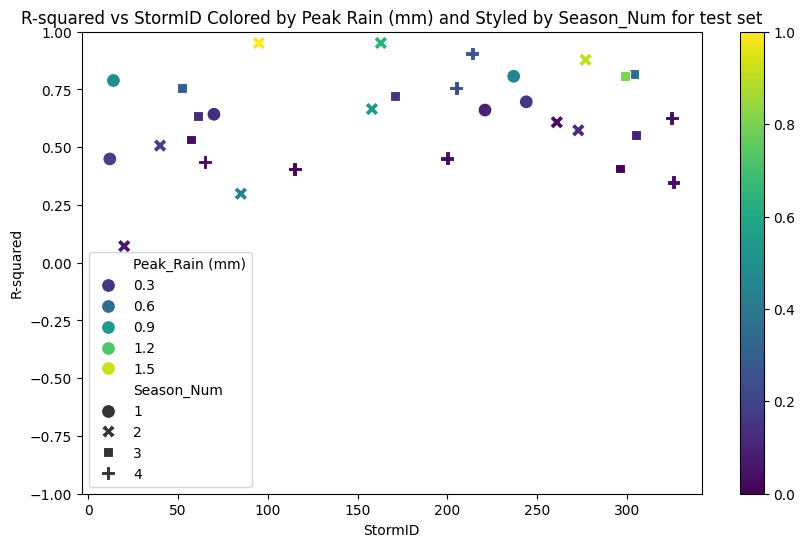

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=result_dataset_test, x='StormID', y='R-squared',
                          hue='Peak_Rain (mm)', style='Season_Num', palette='viridis',
                          s=100)  # Increased point size

# Adding a color bar for 'Peak_Rain (mm)'
plt.colorbar(scatter.collections[0])

# Setting plot title and labels
plt.title('R-squared vs StormID Colored by Peak Rain (mm) and Styled by Season_Num for test set')
plt.xlabel('StormID')
plt.ylabel('R-squared')

# Set the y-axis limit from 1 to -1
plt.ylim(-1, 1)

# Showing the plot
plt.show()

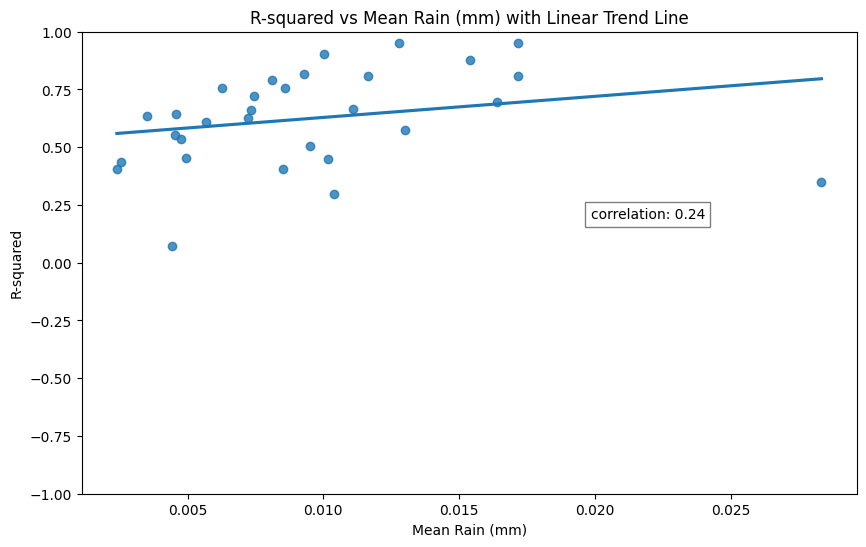

In [ ]:
# Recreating the scatter plot with a regression line and adding a text box to display the correlation value

plt.figure(figsize=(10, 6))
reg_plot = sns.regplot(data=result_dataset_test, x='Mean_Rain (mm)', y='R-squared', ci=None)  # ci=None removes the confidence interval

# Calculating the correlation between 'Mean_Rain (mm)' and 'R-squared'
correlation = result_dataset_test['Mean_Rain (mm)'].corr(result_dataset_test['R-squared'])

# Adding a text box with the correlation value
plt.text(x=max(result_dataset_test['Mean_Rain (mm)']) * 0.7,  # Position the text at 70% of the max x-value
         y=max(result_dataset_test['R-squared']) * 0.2,       # Position the text at 90% of the max y-value
         s=f'correlation: {correlation:.2f}',
         bbox=dict(facecolor='white', alpha=0.5))

# Setting plot title and labels
plt.title('R-squared vs Mean Rain (mm) with Linear Trend Line')
plt.xlabel('Mean Rain (mm)')
plt.ylabel('R-squared')

plt.ylim(-1, 1)

# Showing the plot
plt.show()

In [ ]:
result_dataset_test

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num
0,304.0,0.000027,0.920620,5.9436,0.6096,0.009301,2018,3
639,214.0,0.000028,0.901198,4.7752,0.4572,0.010011,2018,4
1116,237.0,0.000043,0.849162,11.9888,0.7620,0.017176,2018,1
1814,14.0,0.000075,0.828574,3.9624,0.8128,0.008120,2014,1
2302,52.0,0.000026,0.812453,5.1308,0.5080,0.008580,2014,3
2900,205.0,0.000055,0.778542,3.0988,0.4064,0.006286,2018,4
3393,171.0,0.000024,0.768699,2.6924,0.3048,0.007458,2017,3
3754,221.0,0.000015,0.670070,8.0264,0.2032,0.007323,2018,1
4850,61.0,0.000012,0.660600,4.7752,0.2540,0.003496,2014,3
6216,70.0,0.000027,0.650329,3.4544,0.2540,0.004557,2015,1


In [ ]:
# Adding a new column to each dataset to indicate whether it's from train or test
result_dataset_train['Type'] = 'train'
result_dataset_test['Type'] = 'test'

# Merging the datasets vertically
merged_dataset = pd.concat([result_dataset_train, result_dataset_test], ignore_index=True)

In [ ]:
print(list(merged_dataset))

['StormID', 'MSE', 'R-squared', 'Accumulated_Rain (mm)', 'Peak_Rain (mm)', 'Mean_Rain (mm)', 'Year', 'Season_Num', 'Type']


In [ ]:
# Determine thresholds for 'Accumulated_Rain (mm)'
thresholds = merged_dataset['Accumulated_Rain (mm)'].quantile([0.33, 0.66]).values

# Function to categorize storms
def categorize_storm(rainfall):
    if rainfall <= thresholds[0]:
        return 'small'
    elif rainfall <= thresholds[1]:
        return 'medium'
    else:
        return 'large'

# Apply the function to categorize storms
merged_dataset['Storm_Category'] = merged_dataset['Accumulated_Rain (mm)'].apply(categorize_storm)

merged_dataset

,StormID,MSE,R-squared,Accumulated_Rain (mm),Peak_Rain (mm),Mean_Rain (mm),Year,Season_Num,Type,Storm_Category
0,145.0,0.000019,0.952346,1.0668,0.6604,0.012405,2017,2,train,small
1,153.0,0.000014,0.948698,1.7780,0.5080,0.008759,2017,2,train,small
2,125.0,0.000035,0.936306,1.5748,0.7112,0.011013,2017,1,train,small
3,14.0,0.000035,0.919680,3.9624,0.8128,0.008120,2014,1,train,large
4,2.0,0.000067,0.913930,11.7856,1.8288,0.023857,2014,1,train,large
...,...,...,...,...,...,...,...,...,...,...
111,305.0,0.000044,-0.360896,5.5880,0.2032,0.004532,2018,3,test,large
112,213.0,0.000023,-0.454200,0.9652,0.1016,0.006657,2018,4,test,small
113,234.0,0.000056,-0.655218,0.5080,0.2540,0.005131,2018,1,test,small
114,233.0,0.000028,-0.902398,0.5588,0.1016,0.006279,2018,1,test,small


In [ ]:
merged_dataset_train = merged_dataset[merged_dataset['Type'] == 'train']
merged_dataset_test = merged_dataset[merged_dataset['Type'] == 'test']

Trainset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_train.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.750117
medium    0.591962
small     0.471983
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2014    0.534065
2015    0.652819
2017    0.688893
2018    0.490686
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.717799
2    0.597038
3    0.563954
4    0.535078
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_train.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
train    0.607563
Name: R-squared, dtype: float64


Testset

In [ ]:
# Calculating the mean R-squared value for each storm category
mean_r_squared_by_category = merged_dataset_test.groupby('Storm_Category')['R-squared'].mean()
print(mean_r_squared_by_category)

Storm_Category
large     0.507777
medium    0.656981
small    -0.173277
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Year')['R-squared'].mean()
print(mean_r_squared_by_category)

Year
2018    0.290406
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Season_Num')['R-squared'].mean()
print(mean_r_squared_by_category)

Season_Num
1    0.162720
2    0.616727
3    0.263863
4    0.243633
Name: R-squared, dtype: float64


In [ ]:
mean_r_squared_by_category = merged_dataset_test.groupby('Type')['R-squared'].mean()
print(mean_r_squared_by_category)

Type
test    0.290406
Name: R-squared, dtype: float64
